In [238]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns

from datetime import datetime

# Отрисовка графиков
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import os
#Прогноз
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.trend import TrendForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.utils import plotting

#Вывод в PDF
import glob
#!pip install fpdf
import fpdf
from fpdf import FPDF
from pathlib import Path


In [239]:
#Файлы данных
population_csv = 'Численность городского населения по полу и возрасту Город Киров.csv'
birth_rate_koef_csv = 'Общий коэффициент рождаемости.csv'
birth_rate_age_csv = 'Возрастные коэффициенты рождаемости КО.csv'
births_number_csv = 'Число родившихся.csv'
dou_csv = 'Число ДОУ.csv'
dou_students_number_csv = 'Численность воспитанников ДОУ.csv'
dou_place_number_csv = 'Число мест в ДОУ.csv'

In [240]:
#Настройки PDF
pdf = FPDF(orientation="P", unit="mm", format="A4")
pdf.add_font('DejaVu', '', f'font/DejaVuSansCondensed.ttf', uni=True)
pdf.add_font('DejaVuBold', '', f'font/DejaVuSansCondensed-Bold.ttf', uni=True)
pdf_filename = f'pdf/report.pdf'

In [241]:
population_df=pd.read_csv(population_csv, sep=';', index_col=0, encoding='cp1251', header = [1,2])
population_df.dropna(axis=1, how='all', inplace=True)
population_df.index.name = 'Возраст'

In [242]:
sex_index = []
year_index = []
col=''
for column in population_df.columns:
    if "Unnamed" not in column[0]:
        sex_index.append(column[0])
        year_index.append(column[1])
        col=column[0]
    else:
        sex_index.append(col)
        year_index.append(column[1])
population_df.columns = pd.MultiIndex.from_arrays([sex_index,year_index], names=('Пол', 'Год'))

In [243]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return path

In [244]:
def plot_timeseries(data, title=None, figsize=(12, 4), linestyle='-', marker = None):
    """Отрисовка линейного графика"""

    fig, ax = plt.subplots(figsize=figsize, sharex=True)

    for column in data.columns:
        ax.plot(data.index, data[column],linestyle=linestyle, label=column, linewidth=3, marker =marker)

    #  Добавляем линии основной сетки:
    ax.grid(which='major', color = 'gray', linestyle = ':')
    ax.set_xlabel(data.index.name)
    ax.set_ylabel('Количество')
    #ax.set_xlim(left=-0.1,right=23.1)
    #y_max = data.max().max()
    #ax.set_yticks(np.arange(0, y_max+1, y_max/5))
#    fig.set_figwidth(24)
#    fig.set_figheight(8)
#    fig.suptitle(title)
    ax.set_title(title)
    if data.shape[1] > 1:
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    if title == None:
        title = 'timeseries_img'
    path = save_fig(title)
    
    plt.show()

    return path

In [245]:
def plot_bar(data, title=None, figsize=(12, 8)):
    """Отрисовка стека столбцов графика"""

    x = np.arange(len(data.index))  # the label locations
    width = 0.9#1/len(data.index)  # the width of the bars
    multiplier = 0
    bottom = np.zeros(len(data.index))
    
    fig, ax = plt.subplots(figsize=figsize, sharex=True)
    for column in data.columns:
        offset = width * multiplier
#        rects = ax.bar(x + offset, data[column], width=width, label=column)
        rects = ax.bar(data.index, data[column], width=width, label=column, bottom=bottom)
#    rects = ax.bar(x + offset, df_children.columns, df_children.loc['1'], label=attribute)
        ax.bar_label(rects, padding=-1, label_type='center', fontsize = 'small')
        multiplier += 1
        bottom += data[column]

    #p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
        
    #  Добавляем линии основной сетки:
    ax.grid(which='major', axis = 'y', color = 'gray', linestyle = ':')
    ax.set_xlabel(data.index.name)
    ax.set_ylabel('Количество')
#    fig.set_figwidth(24)
#    fig.set_figheight(8)
#    fig.suptitle(title)
    ax.set_title(title, fontsize = 'medium')
    if data.shape[1] > 1:
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        
    if title == None:
        title = 'bar_img'
    path = save_fig(title)
    
    plt.show()

    return path

In [246]:
def subplot_bar(data1, data2, title=[None, None], figsize=(12, 8), sharey = False):
    """Отрисовка стека столбцов графика"""

    #x = np.arange(len(data.index))  # the label locations
    width = 0.9#1/len(data.index)  # the width of the bars
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=sharey, layout='constrained')

    bottom = np.zeros(len(data1.index))
    for column in data1.columns:
        rects = ax1.bar(data1.index, data1[column], width=width, label=column, bottom=bottom)
        ax1.bar_label(rects, padding=-1, label_type='center', fontsize = 'small')
        bottom += data1[column]
    #  Добавляем линии основной сетки:
    ax1.grid(which='major', axis = 'y', color = 'gray', linestyle = ':')
    ax1.set_xlabel(data1.index.name)
    ax1.set_ylabel('Количество')
    if data1.shape[1] > 1:
        ax1.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax1.set_title(title[0], fontsize = 'medium')
    
    bottom = np.zeros(len(data2.index))
    for column in data2.columns:
        rects = ax2.bar(data2.index, data2[column], width=width, label=column, bottom=bottom)
        ax2.bar_label(rects, padding=-1, label_type='center', fontsize = 'small')
        bottom += data2[column]
    #  Добавляем линии основной сетки:
    ax2.grid(which='major', axis = 'y', color = 'gray', linestyle = ':')
    ax2.set_xlabel(data2.index.name)
    if not sharey:
        ax2.set_ylabel('Количество')
    if data2.shape[1] > 1:
        ax2.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax2.set_title(title[1], fontsize = 'medium')
        
        
#    fig.set_figwidth(24)
#    fig.set_figheight(8)
#    fig.suptitle(title)
    if title[0] == None or title[1] == None:
        title = 'subplot_bar_img'
    path = save_fig(f'{title[0]}_{title[1]}', tight_layout=False)
    plt.show()
    
    return path

In [247]:
def show_heatmap(data, title=None, figsize=(12, 8), vmax = None, center=None, square=False, annot=False):
    sns.set_theme(style="white")

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with correct aspect ratio
    sns.heatmap(data, cmap=cmap, vmax=vmax, center=center,
                square=square, linewidths=.5, cbar_kws={"shrink": .5},
                annot=annot, fmt=".0f", annot_kws={"size":8})
    if title == None:
        title = 'heatmap_img'
    path = save_fig(title)

    return path

In [248]:
def pdf_add_page(page_title, img_paths, description):
    pdf.add_page()
    pdf.set_font(family="DejaVuBold", size=12)
#    pdf.cell(w=50, h=8, txt=page_title, ln=1)
    pdf.multi_cell(w=0, h=8, txt=page_title, align='C')
    for img_path in img_paths:
        pdf.image(img_path, w=190)
    pdf.set_font(family="DejaVu", size=10)
    pdf.multi_cell(w=0, h=6, txt=description)

In [249]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 0 to 100 и более лет
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Всего, 2012)    77 non-null     int64  
 1   (Всего, 2013)    77 non-null     int64  
 2   (Всего, 2014)    77 non-null     int64  
 3   (Всего, 2015)    77 non-null     int64  
 4   (Всего, 2016)    77 non-null     int64  
 5   (Всего, 2017)    77 non-null     int64  
 6   (Всего, 2018)    77 non-null     int64  
 7   (Всего, 2019)    77 non-null     int64  
 8   (Всего, 2020)    77 non-null     int64  
 9   (Всего, 2021)    77 non-null     int64  
 10  (Всего, 2022)    75 non-null     float64
 11  (Всего, 2023)    75 non-null     float64
 12  (Женщины, 2012)  77 non-null     int64  
 13  (Женщины, 2013)  77 non-null     int64  
 14  (Женщины, 2014)  77 non-null     int64  
 15  (Женщины, 2015)  77 non-null     int64  
 16  (Женщины, 2016)  77 non-null     int64  
 17  (Женщины, 

In [250]:
births_number_df=pd.read_csv(births_number_csv, sep=';', index_col=0, encoding='cp1251', header = [1])
births_number_df.dropna(axis=1, how='all', inplace=True)
births_number_df

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Город Киров,5556,5805,6374,6474,6768,7287,7326,6245,5939,5313,4893,4910,4385


In [251]:
population_df['Женщины']

Год,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Возраст,,,,,,,,,,,,
0,2637,2924,2940,3125,3389,3382,2873,2784,2472,2273,2374.0,2040.0
1,2658,2688,2938,2968,3155,3435,3442,2913,2817,2487,2187.0,2408.0
2,2693,2703,2709,2989,3006,3166,3479,3525,2985,2848,2422.0,2224.0
3,2512,2728,2720,2762,3051,3040,3205,3527,3562,3060,2804.0,2463.0
4,2380,2528,2729,2769,2776,3071,3066,3252,3563,3616,3080.0,2826.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80-84 года,7730,7757,7422,7172,6894,6905,7536,8123,8838,8995,8242.0,7169.0
85-89 лет,3670,3933,4226,4348,4581,4587,4618,4372,4241,3953,3385.0,3694.0
90-94 года,852,964,1060,1218,1358,1538,1624,1695,1746,1787,1318.0,1187.0


In [252]:
population_df.xs('2022', axis=1, level=1, drop_level=False).droplevel('Год', axis=1)

Пол,Всего,Женщины,Мужчины
Возраст,,,
0,4834.0,2374.0,2460.0
1,4485.0,2187.0,2298.0
2,4997.0,2422.0,2575.0
3,5768.0,2804.0,2964.0
4,6299.0,3080.0,3219.0
...,...,...,...
80-84 года,10702.0,8242.0,2460.0
85-89 лет,4208.0,3385.0,823.0
90-94 года,1608.0,1318.0,290.0


In [253]:
population_df['Всего']

Год,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Возраст,,,,,,,,,,,,
0,5468,5971,6066,6335,6959,6924,5927,5666,5086,4669,4834.0,4188.0
1,5565,5553,5990,6131,6370,7025,7049,6017,5755,5127,4485.0,4897.0
2,5502,5652,5591,6079,6200,6436,7134,7206,6142,5833,4997.0,4565.0
3,5212,5532,5698,5678,6160,6274,6509,7239,7284,6295,5768.0,5090.0
4,4882,5249,5548,5783,5742,6228,6328,6596,7321,7396,6299.0,5807.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80-84 года,9908,9921,9440,9153,8850,8930,9826,10600,11499,11597,10702.0,9312.0
85-89 лет,4467,4849,5225,5387,5624,5607,5619,5358,5192,4842,4208.0,4607.0
90-94 года,1011,1121,1208,1389,1574,1801,1905,1998,2069,2111,1608.0,1438.0


In [254]:
population_df['Всего'].index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70-74', '75-79',
       '80-84 года', '85-89 лет', '90-94 года', '95-99 лет',
       '100 и более лет'],
      dtype='object', name='Возраст')

In [255]:
#df['Всего'].pivot(columns=df.index, values=df.columns)
#df['Всего'].pivot(index=[df['Всего'].columns], columns=[df['Всего'].index])
dft = population_df['Всего'].iloc[0:70].T
dft.index = dft.index.astype('int64')
dft

Возраст,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
Год,,,,,,,,,,,,,,,,,,,,,
2012,5468.0,5565.0,5502.0,5212.0,4882.0,4483.0,4342.0,4502.0,4239.0,4272.0,...,6704.0,6489.0,6603.0,5177.0,5447.0,4494.0,2292.0,1511.0,1123.0,2077.0
2013,5971.0,5553.0,5652.0,5532.0,5249.0,4902.0,4537.0,4411.0,4535.0,4271.0,...,6751.0,6578.0,6372.0,6445.0,5064.0,5323.0,4390.0,2226.0,1461.0,1094.0
2014,6066.0,5990.0,5591.0,5698.0,5548.0,5297.0,4963.0,4653.0,4454.0,4558.0,...,6555.0,6662.0,6423.0,6220.0,6309.0,4955.0,5203.0,4301.0,2156.0,1421.0
2015,6335.0,6131.0,6079.0,5678.0,5783.0,5628.0,5389.0,5115.0,4688.0,4499.0,...,7095.0,6458.0,6555.0,6358.0,6102.0,6216.0,4863.0,5129.0,4216.0,2104.0
2016,6959.0,6370.0,6200.0,6160.0,5742.0,5847.0,5694.0,5539.0,5124.0,4721.0,...,7101.0,6993.0,6350.0,6465.0,6234.0,5986.0,6083.0,4739.0,5000.0,4089.0
2017,6924.0,7025.0,6436.0,6274.0,6228.0,5790.0,5950.0,5810.0,5545.0,5172.0,...,6596.0,6991.0,6883.0,6279.0,6359.0,6139.0,5888.0,5947.0,4649.0,4873.0
2018,5927.0,7049.0,7134.0,6509.0,6328.0,6353.0,5931.0,6095.0,5883.0,5587.0,...,7130.0,6514.0,6919.0,6798.0,6175.0,6220.0,6051.0,5810.0,5824.0,4553.0
2019,5666.0,6017.0,7206.0,7239.0,6596.0,6430.0,6505.0,6110.0,6165.0,5952.0,...,7023.0,7042.0,6424.0,6843.0,6723.0,6084.0,6116.0,5925.0,5693.0,5694.0
2020,5086.0,5755.0,6142.0,7284.0,7321.0,6693.0,6594.0,6657.0,6177.0,6220.0,...,7124.0,6958.0,6957.0,6341.0,6740.0,6647.0,5988.0,5993.0,5800.0,5577.0


Saving figure Корреляция возрастных групп


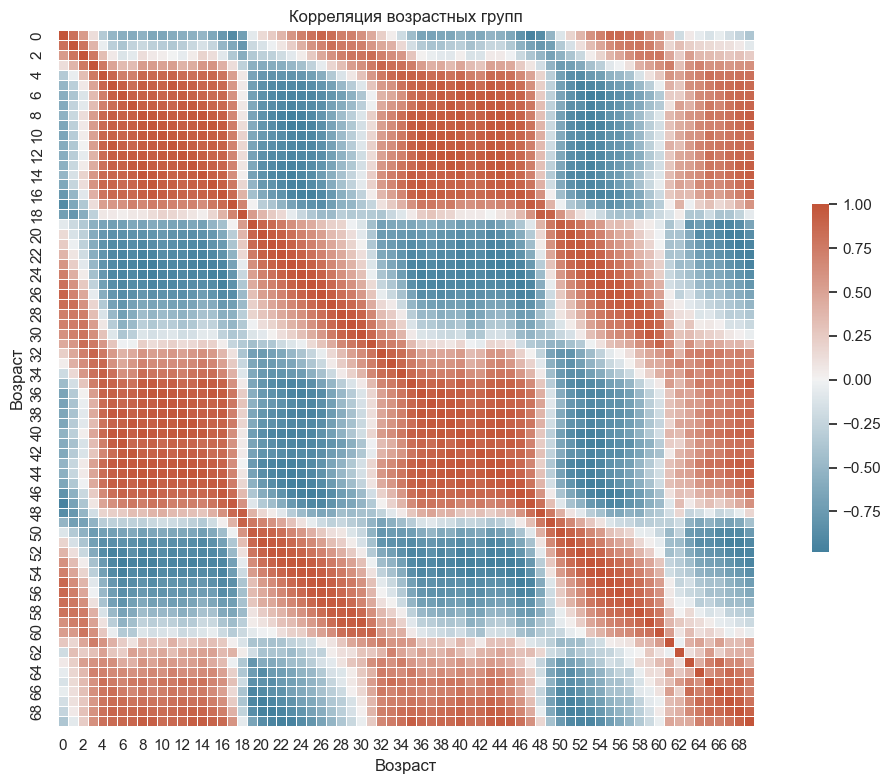

In [256]:
dft_corr = dft.corr()
img_path = show_heatmap(dft_corr, vmax=1.0, center=0, square=True, title="Корреляция возрастных групп")

page_title="Взаимосвязь возрастных групп за период с 2012г по 2023г"
description = '''На графике представлена корреляция численности населения в возрасте от 0 до 69 лет.
Как видно, высокая положительная корреляция (квадраты коричневого цвета) показывают поколения дети - родители - бабушки, дедушки. 
Так же можно отметить размер поколения: огромная группа детей в возрасте от 4 до 17 лет показывает о росте рождаемости в период 2005 - 2015гг.
Также можно отметить соразмерность группы детей и группы родителей. Следовательно по небольшому размеру группы 20-35 лет можно предположить снижение рождаемости в ближайшие годы.'''

pdf_add_page(page_title, [img_path], description)

In [257]:
df_children = population_df['Всего'].iloc[0:20]
df_children

Год,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Возраст,,,,,,,,,,,,
0,5468,5971,6066,6335,6959,6924,5927,5666,5086,4669,4834.0,4188.0
1,5565,5553,5990,6131,6370,7025,7049,6017,5755,5127,4485.0,4897.0
2,5502,5652,5591,6079,6200,6436,7134,7206,6142,5833,4997.0,4565.0
3,5212,5532,5698,5678,6160,6274,6509,7239,7284,6295,5768.0,5090.0
4,4882,5249,5548,5783,5742,6228,6328,6596,7321,7396,6299.0,5807.0
5,4483,4902,5297,5628,5847,5790,6353,6430,6693,7420,7138.0,6355.0
6,4342,4537,4963,5389,5694,5950,5931,6505,6594,6822,7345.0,7216.0
7,4502,4411,4653,5115,5539,5810,6095,6110,6657,6752,6124.0,7488.0
8,4239,4535,4454,4688,5124,5545,5883,6165,6177,6717,5975.0,6179.0


Saving figure Численность возрастных групп


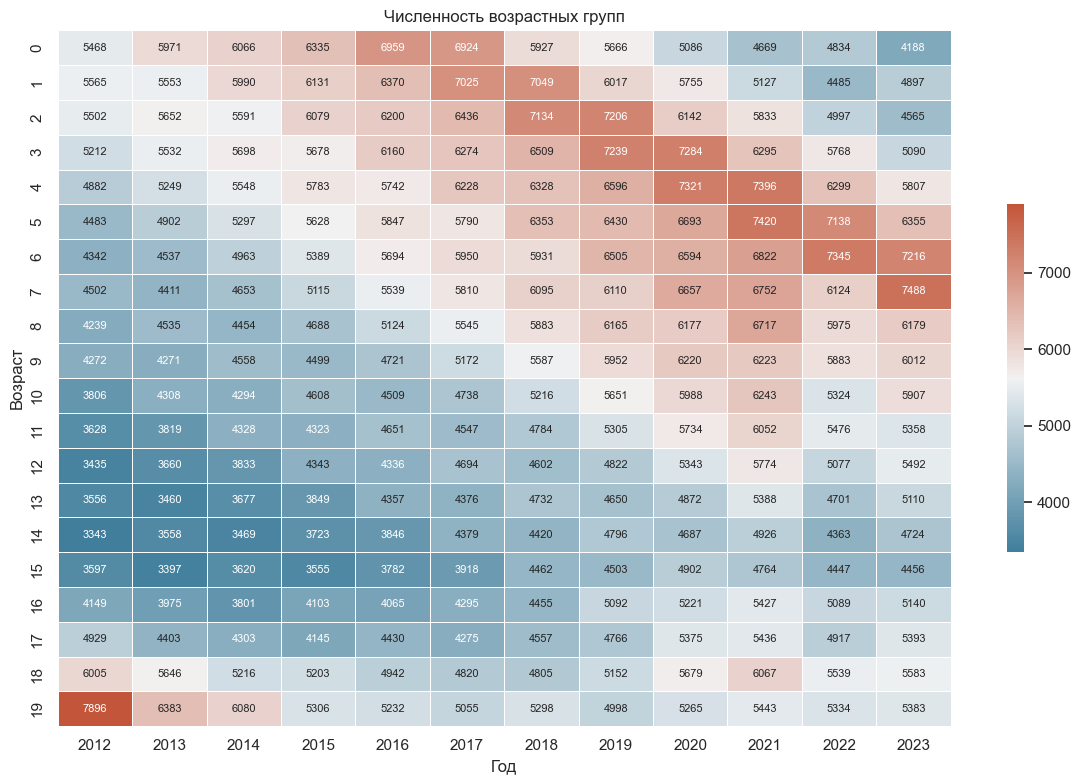

In [258]:
img_path = show_heatmap(df_children, title="Численность возрастных групп", annot=True)

page_title="Численность детей до 19 лет за период с 2012г по 2023г"
description = '''На графике видно пик рождаемости приходится на 2016-2017гг, далее рождаемость снижается. На 2023 год наибольшая группа - дети 6-7 лет. наименьшие группы - новорождённые и дети 14-15 лет'''

pdf_add_page(page_title, [img_path], description)

Saving figure Число родившихся, человек, значение показателя за год


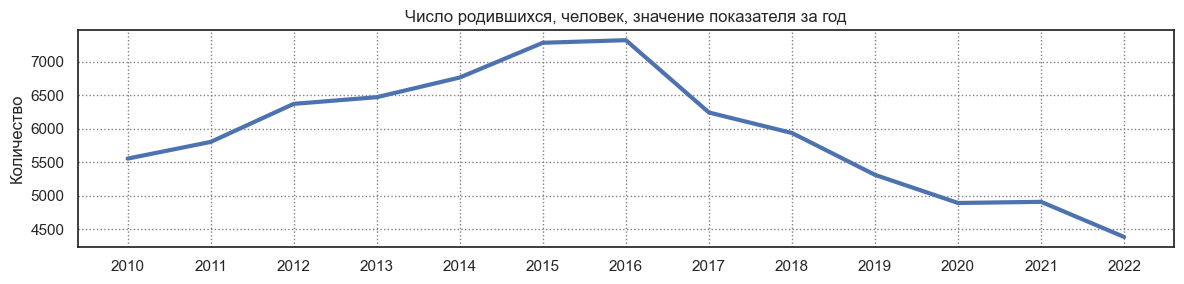

Saving figure Количество детей в возрасте 1 год


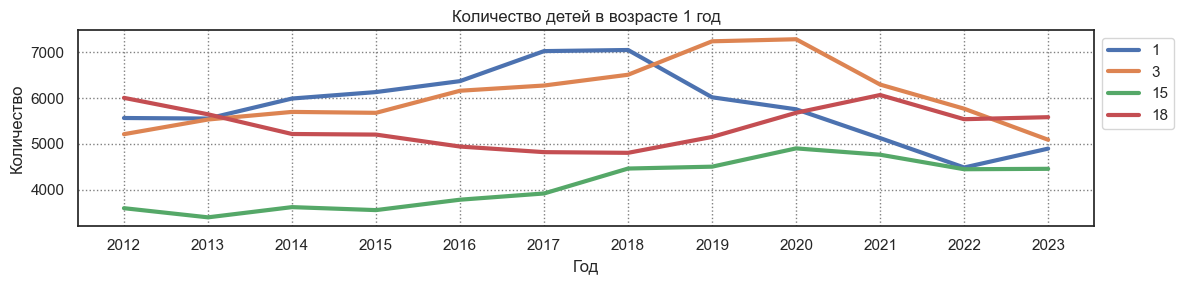

'.\\images\\Количество детей в возрасте 1 год.png'

In [259]:
plot_timeseries(births_number_df.T,title='Число родившихся, человек, значение показателя за год', figsize = (12,3))
plot_timeseries(df_children.T[['1','3','15','18']],title='Количество детей в возрасте 1 год', figsize = (12,3))

Saving figure Число родившихся, человек, значение показателя за год


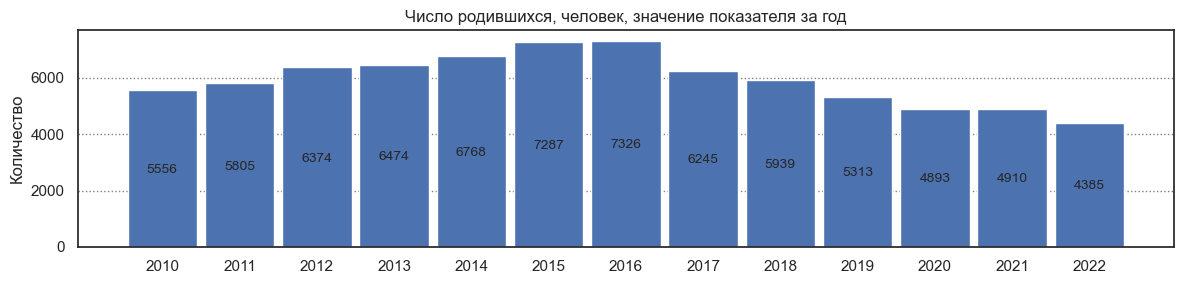

Saving figure Количество детей в возрасте 1-3 года


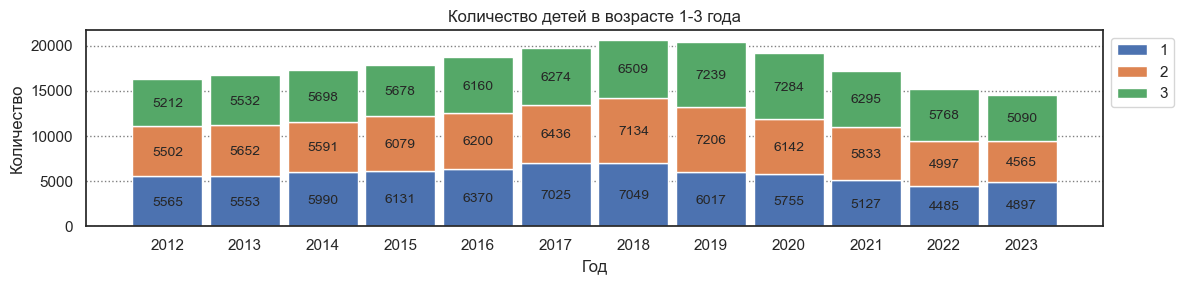

Saving figure Количество детей в возрасте до 2 лет


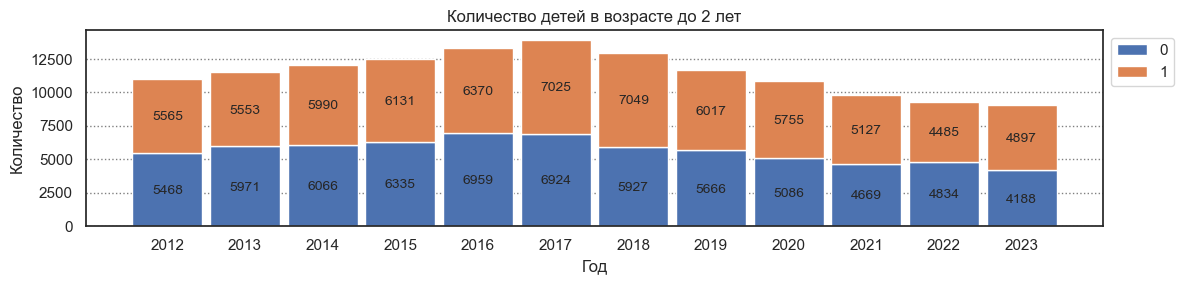

In [260]:
img_paths = [None,None,None]
img_paths[0] = plot_bar(births_number_df.T, title='Число родившихся, человек, значение показателя за год', figsize = (12,3))
img_paths[1] = plot_bar(df_children.iloc[1:4].T, title='Количество детей в возрасте 1-3 года', figsize = (12,3))
img_paths[2] = plot_bar(df_children.iloc[0:2].T, title='Количество детей в возрасте до 2 лет', figsize = (12,3))
page_title="Число детей от 1 года до 3 лет по годам за период с 2012г по 2023г"
description = '''На графиках показаны количество родившихся детей, а также группы детей от года до 3 лет, и до года.'''
pdf_add_page(page_title, img_paths, description)

In [261]:
df_females = population_df['Женщины'].iloc[15:50]

Saving figure Численность женщин детородного возраста


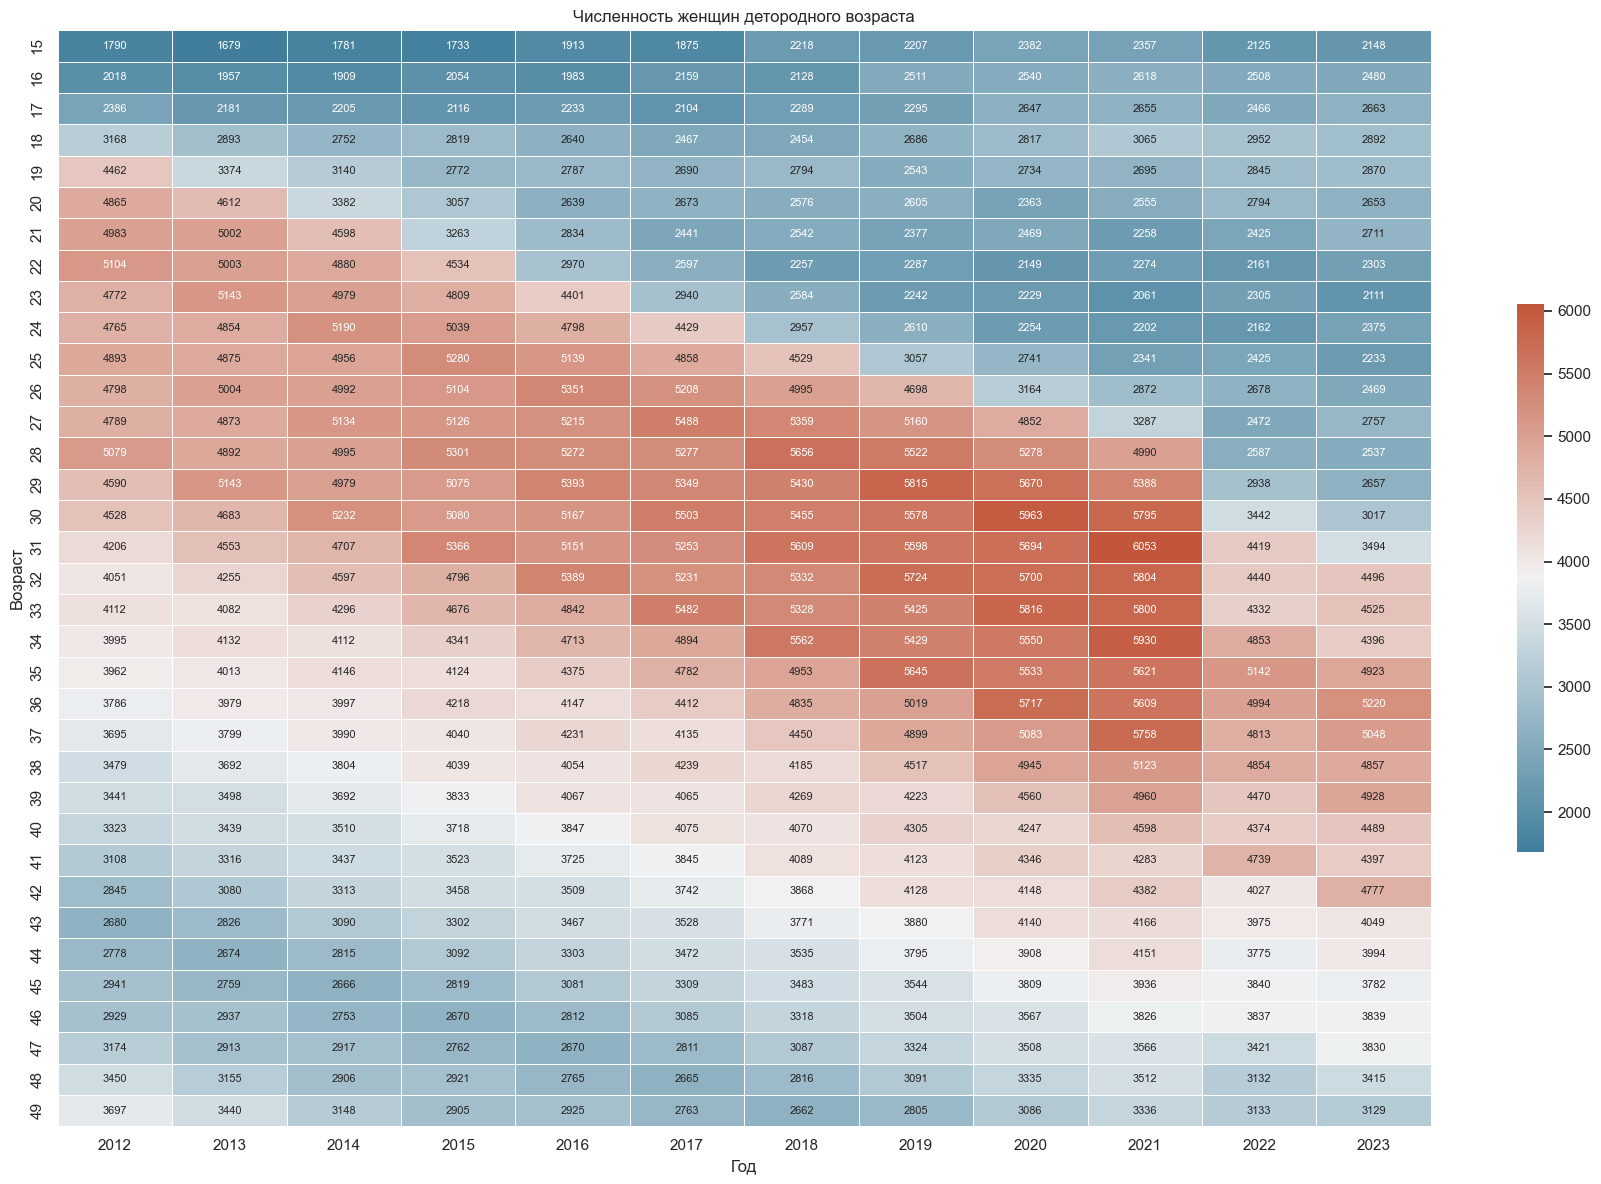

In [262]:
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(df_females,annot=True, fmt=".0f", annot_kws={"size":8}, cmap="crest")
img_path = show_heatmap(df_females, title="Численность женщин детородного возраста", figsize=(18, 12), annot=True)

page_title="Численность женщин детородного возраста (15-49 лет) за период с 2012г по 2023г"
description = '''На графике видно наибольшая группа женщин 35-40 лет, Количество женщин до 30 существенно ниже. Из данных на этом графике можно сделать предположение, что рождаемость первых и вторых детей будет снижаться. Можно ожидать дополнительный вклад в рожаемость третьих и далее детей в семье, но этот факт зависит от ряда экономических и политических факторов.'''

pdf_add_page(page_title, [img_path], description)

Saving figure Количество женщин в возрасте 20-34 лет


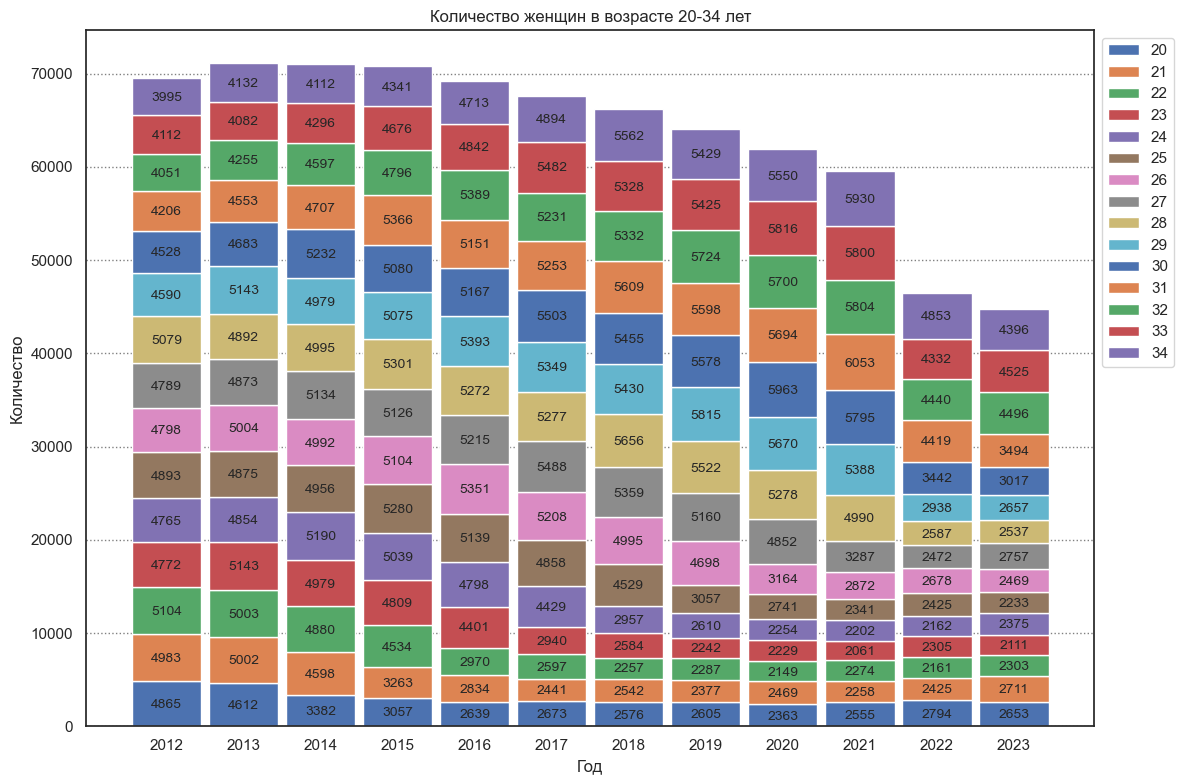

In [263]:
img_path = plot_bar(df_females.loc['20':'34'].T, title='Количество женщин в возрасте 20-34 лет')
page_title="Доля женщин в возрасте 20-34 лет за период с 2012г по 2023г"
description = '''На графике видно снижение количества женщин в возрасте 20-34 года.'''

pdf_add_page(page_title, [img_path], description)

Saving figure Количество женщин в возрасте 15 - 32 года


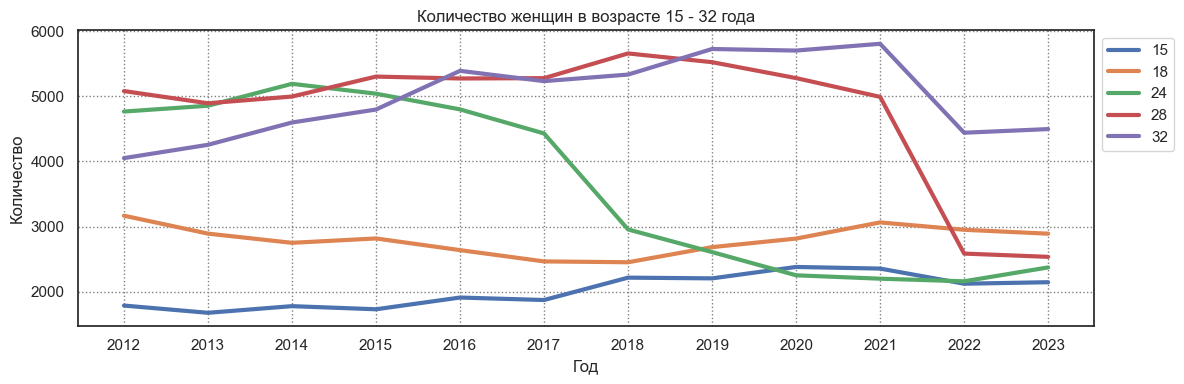

'.\\images\\Количество женщин в возрасте 15 - 32 года.png'

In [264]:
plot_timeseries(df_females.T[['15','18','24','28','32']],title='Количество женщин в возрасте 15 - 32 года')

Saving figure Количество женщин в возрасте 15 - 32 года


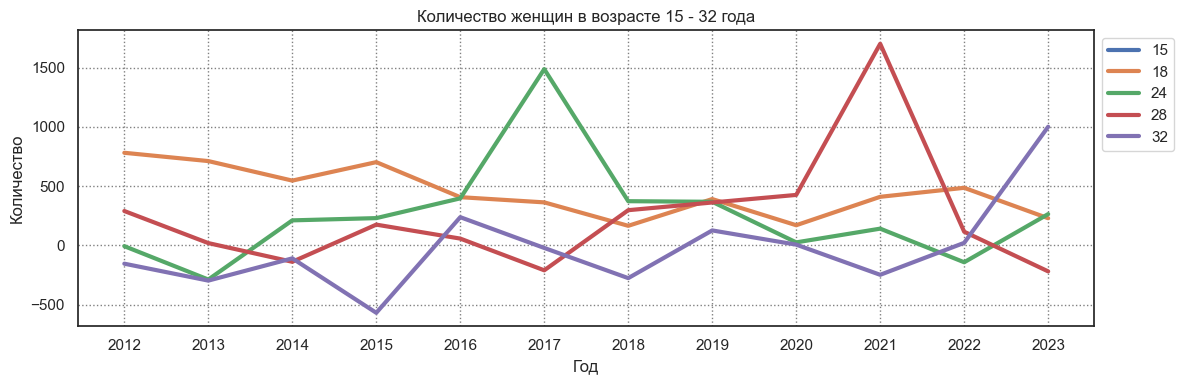

'.\\images\\Количество женщин в возрасте 15 - 32 года.png'

In [265]:
df_females_diff = df_females.diff().T
plot_timeseries(df_females_diff[['15','18','24','28','32']],title='Количество женщин в возрасте 15 - 32 года')

In [266]:
def get_corr(df1, df2):
    df_corr = DataFrame()
    for column in df2.columns:
        df_column_corr = df1.corrwith(df2[column], axis=0)
        df_corr[column]=df_column_corr
    return df_corr

In [267]:
df_corr = get_corr(df_females.T, df_children.T)
df_corr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Возраст,,,,,,,,,,,,,,,,,,,,
15,-0.602970,-0.209341,0.177661,0.620410,0.867759,0.868769,0.805394,0.854370,0.929246,0.954630,0.916587,0.912078,0.854633,0.916635,0.898047,0.991376,0.900713,0.767338,0.177428,-0.493882
16,-0.737846,-0.505939,-0.083798,0.430367,0.793591,0.857342,0.883057,0.846571,0.907544,0.939817,0.923119,0.914394,0.897662,0.859275,0.898839,0.906394,0.993068,0.807274,0.373258,-0.459656
17,-0.897165,-0.661064,-0.425755,0.087253,0.523245,0.609845,0.641944,0.731369,0.666189,0.738437,0.740907,0.728271,0.707165,0.715734,0.611843,0.769587,0.828611,0.984285,0.667807,-0.037129
18,-0.629894,-0.822579,-0.664414,-0.461211,-0.143435,-0.055941,-0.055204,-0.083488,-0.107352,-0.041586,0.009720,0.026908,-0.011966,-0.080452,-0.164380,-0.017959,0.245232,0.535085,0.945484,0.613375
19,-0.042427,-0.179393,-0.353803,-0.583197,-0.706938,-0.732576,-0.687889,-0.614038,-0.676694,-0.612122,-0.665504,-0.684970,-0.696629,-0.638790,-0.692945,-0.531707,-0.439451,-0.011917,0.483520,0.988567
20,0.103434,-0.152067,-0.295878,-0.597726,-0.777242,-0.821533,-0.806477,-0.785954,-0.785064,-0.758082,-0.746891,-0.803967,-0.811455,-0.810721,-0.783494,-0.720546,-0.577417,-0.245771,0.406885,0.912592
21,0.190548,-0.062919,-0.300298,-0.588892,-0.803791,-0.873673,-0.870973,-0.836320,-0.877821,-0.825538,-0.790636,-0.828360,-0.865757,-0.878440,-0.875897,-0.786623,-0.714229,-0.353725,0.282262,0.850968
22,0.345974,0.043084,-0.213982,-0.578155,-0.787502,-0.878577,-0.904234,-0.894094,-0.938410,-0.909845,-0.838033,-0.860032,-0.872518,-0.928294,-0.923547,-0.883223,-0.795619,-0.520099,0.175833,0.743584
23,0.577463,0.207378,-0.104089,-0.503724,-0.795547,-0.868388,-0.908125,-0.916482,-0.965572,-0.973715,-0.904159,-0.880809,-0.899067,-0.931684,-0.964551,-0.944886,-0.912769,-0.681344,-0.055015,0.587713


Saving figure Корреляция количества женщин детородного возраста и детей до 19 лет


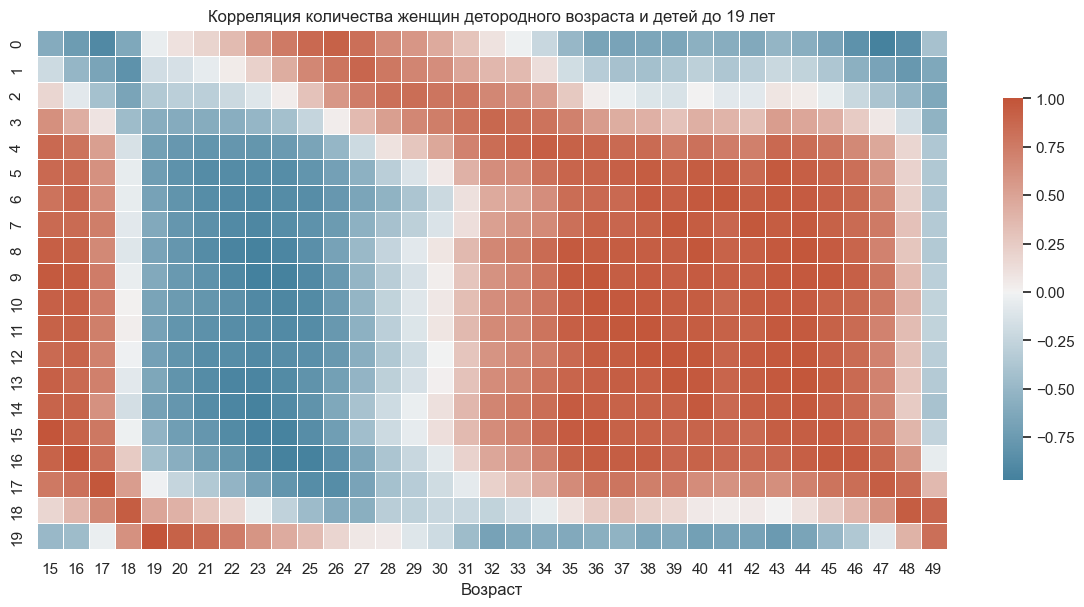

In [268]:
#show_heatmap(df_corr.T, title="Корреляция количества женщин детородного возраста и детей до 19 лет")

img_path = show_heatmap(df_corr.T, vmax=1.0, center=0, square=True, title="Корреляция количества женщин детородного возраста и детей до 19 лет")

page_title="Взаимосвязь численности детей и женщин детородноговозраста за период с 2012г по 2023г"
description = '''На графике представлена корреляция численности детей в возрасте от 0 до 19 лет и женщин в возрасте 15-49 лет.
Как видно, высокая положительная корреляция (квадраты коричневого цвета) показывают поколения дети - родители. 
Так же можно отметить размер поколения: огромная группа детей в возрасте от 4 до 17 лет показывает о росте рождаемости в период 2005 - 2015гг.
Также можно отметить соразмерность группы детей и группы родителей. Следовательно по небольшому размеру группы 20-30 лет можно предположить снижение рождаемости в ближайшие годы.'''

pdf_add_page(page_title, [img_path], description)

In [269]:
df_children

Год,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Возраст,,,,,,,,,,,,
0,5468,5971,6066,6335,6959,6924,5927,5666,5086,4669,4834.0,4188.0
1,5565,5553,5990,6131,6370,7025,7049,6017,5755,5127,4485.0,4897.0
2,5502,5652,5591,6079,6200,6436,7134,7206,6142,5833,4997.0,4565.0
3,5212,5532,5698,5678,6160,6274,6509,7239,7284,6295,5768.0,5090.0
4,4882,5249,5548,5783,5742,6228,6328,6596,7321,7396,6299.0,5807.0
5,4483,4902,5297,5628,5847,5790,6353,6430,6693,7420,7138.0,6355.0
6,4342,4537,4963,5389,5694,5950,5931,6505,6594,6822,7345.0,7216.0
7,4502,4411,4653,5115,5539,5810,6095,6110,6657,6752,6124.0,7488.0
8,4239,4535,4454,4688,5124,5545,5883,6165,6177,6717,5975.0,6179.0


Saving figure прирост детей в возрасте до 20 лет


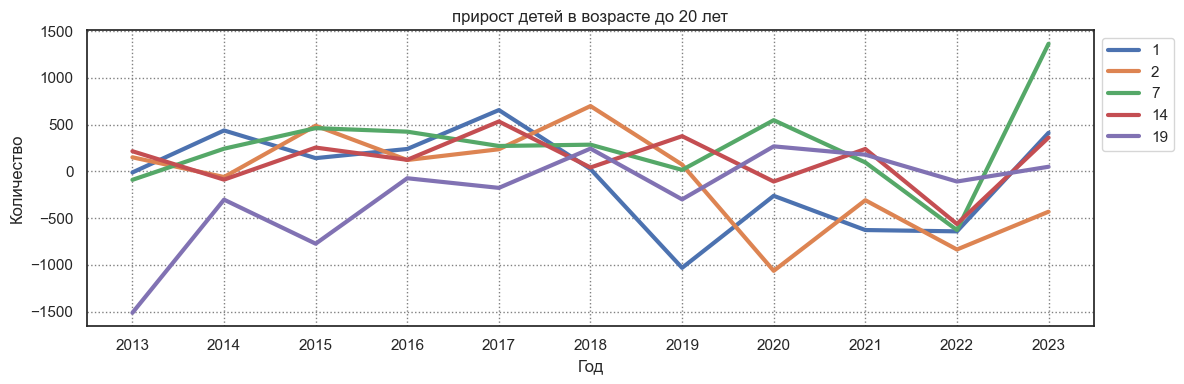

'.\\images\\прирост детей в возрасте до 20 лет.png'

In [270]:
df_children_diff = df_children.T.diff().T
plot_timeseries(df_children_diff.T[['1','2','7','14','19']],title='прирост детей в возрасте до 20 лет')

In [271]:
birth_rate_koef_df=pd.read_csv(birth_rate_koef_csv, sep=';', index_col=0, encoding='cp1251', header = [1])
birth_rate_koef_df.dropna(axis=1, how='all', inplace=True)
#birth_rate_koef_df.index.name = 'Возраст'
birth_rate_koef_df

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Город Киров,"11,2","11,6","12,6","12,7","13,1",14,"13,9","11,8","11,1","9,8",9,9,"8,8"


In [272]:
birth_rate_age_df=pd.read_csv(birth_rate_age_csv, sep=';', index_col=[0,1,2], encoding='cp1251', header = [2])#, dtype = np.float64)
birth_rate_age_df.dropna(axis=1, how='all', inplace=True)
#birth_rate_age_df

In [273]:
birth_rate_age_city_df = birth_rate_age_df.loc['        Кировская область','городское население',:]

Saving figure Возрастные коэффициенты рождаемости КО


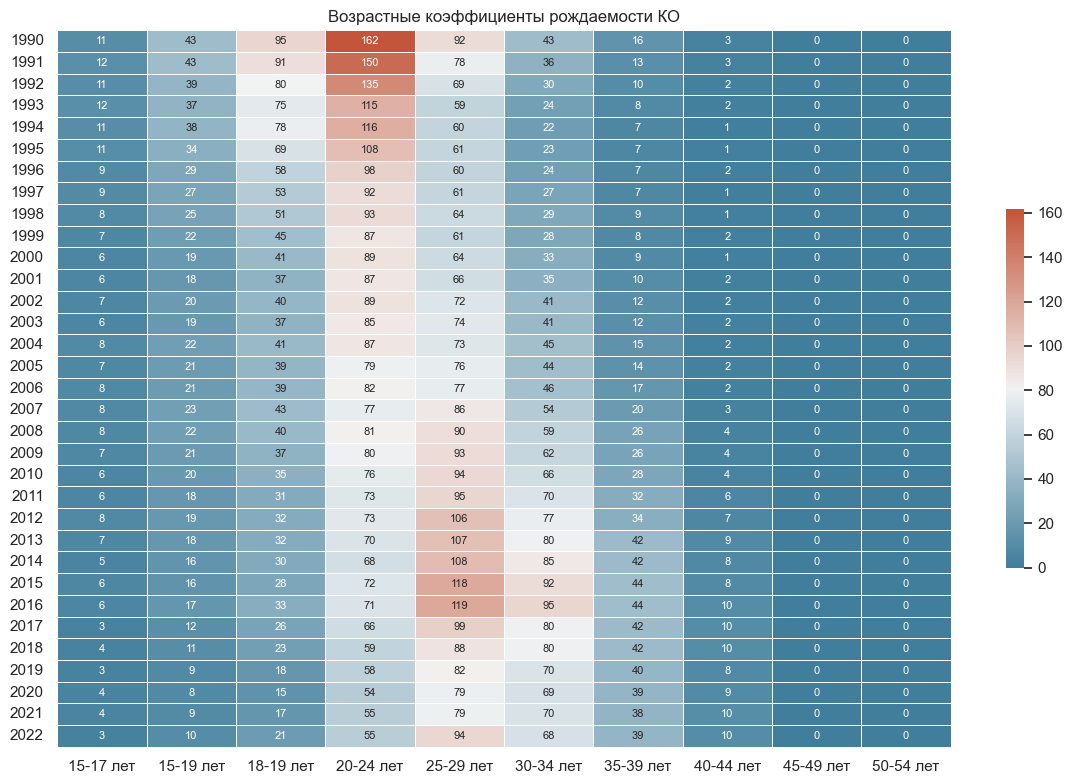

In [274]:
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(birth_rate_age_city_df.T,annot=True, fmt=".1f", annot_kws={"size":8})
img_path = show_heatmap(birth_rate_age_city_df.T, title="Возрастные коэффициенты рождаемости КО", annot=True)

page_title="Возрастные коэффициенты рождаемости по Кировской области за период с 1990г по 2022г"
description = '''На графике видно что во весь период с 1990 по 2022 наибольшее количество детей родилось у женщин в возрасте от 18 до 39 лет. 
Причем следует отметить увеличение возраста рожениц. Если с 1990 по 2006 больше рожали женщины в возрасте 20-25 лет, то 2007 больше рожают женщины 25-29 лет.
Увеличение коэффициента рождаемости для женщин 30-34, 35-39 лет так же показывает увеличение возраста рождения вторых и следуюих детей.
Учитывая что возраст рождения первых детей сдвигается к 25-29 годам можно предположить что всплеск рождаемости можно ожидать когда сегодняшние девочки 3-13 лет достигнут возраста 25-29 лет, то есть не ранее чем через 10-15 лет.
Для справки. Возрастные коэффициенты рождаемости рассчитываются как отношение числа родившихся за год у женщин данной возрастной группы к среднегодовой численности женщин этого возраста.'''

pdf_add_page(page_title, [img_path], description)

Saving figure Возрастные коэффициенты рождаемости Кировская область


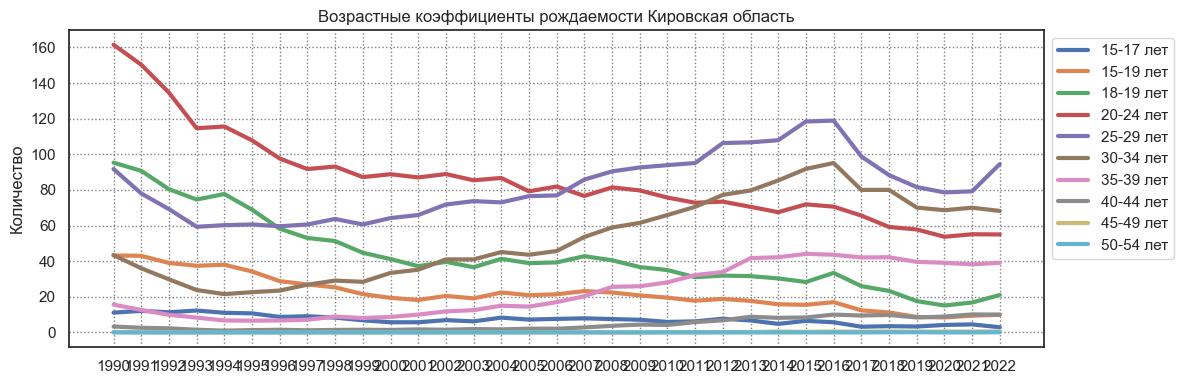

'.\\images\\Возрастные коэффициенты рождаемости Кировская область.png'

In [275]:
plot_timeseries(birth_rate_age_city_df.T,title='Возрастные коэффициенты рождаемости Кировская область')

In [276]:
birth_rate_age_city_df.T.columns

Index(['15-17 лет', '15-19 лет', '18-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', '50-54 лет'],
      dtype='object')

In [277]:
age_groups_columns = [' 0-1 год', ' 2-3 года', ' 4-6 лет', ' 7-10 лет', '11-14 лет', 
                      '15-17 лет', '18-19 лет', '20-24 лет', 
                      '25-29 лет', '30-34 лет', '35-39 лет',
                      '40-44 лет', '45-49 лет']

In [278]:
age_groups = [[0, 1], [2, 3], [4, 5, 6], [7, 8, 9, 10], [11, 12, 13, 14], [15, 16, 17], [18, 19], [20, 21, 22, 23, 24],
              [25, 26, 27, 28, 29], [30, 31, 32, 33, 34], [35, 36, 37, 38, 39], [40, 41, 42, 43, 44],
              [45, 46, 47, 48, 49]]

In [279]:
ages = Series(dtype='object')
for col, indexes in zip(age_groups_columns,age_groups):
    for i in indexes:
        ages.loc[i] = col
ages_str = ages.to_list()
ages_str

[' 0-1 год',
 ' 0-1 год',
 ' 2-3 года',
 ' 2-3 года',
 ' 4-6 лет',
 ' 4-6 лет',
 ' 4-6 лет',
 ' 7-10 лет',
 ' 7-10 лет',
 ' 7-10 лет',
 ' 7-10 лет',
 '11-14 лет',
 '11-14 лет',
 '11-14 лет',
 '11-14 лет',
 '15-17 лет',
 '15-17 лет',
 '15-17 лет',
 '18-19 лет',
 '18-19 лет',
 '20-24 лет',
 '20-24 лет',
 '20-24 лет',
 '20-24 лет',
 '20-24 лет',
 '25-29 лет',
 '25-29 лет',
 '25-29 лет',
 '25-29 лет',
 '25-29 лет',
 '30-34 лет',
 '30-34 лет',
 '30-34 лет',
 '30-34 лет',
 '30-34 лет',
 '35-39 лет',
 '35-39 лет',
 '35-39 лет',
 '35-39 лет',
 '35-39 лет',
 '40-44 лет',
 '40-44 лет',
 '40-44 лет',
 '40-44 лет',
 '40-44 лет',
 '45-49 лет',
 '45-49 лет',
 '45-49 лет',
 '45-49 лет',
 '45-49 лет']

In [280]:
years = df_females.columns
df_females_age = df_females.copy()
df_females_age['Возрастная группа'] = ages_str[15:50]
df_children_age = df_children.copy()
df_children_age['Возрастная группа'] = ages_str[0:20]

In [281]:
df_females_age

Год,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Возрастная группа
Возраст,,,,,,,,,,,,,
15,1790,1679,1781,1733,1913,1875,2218,2207,2382,2357,2125.0,2148.0,15-17 лет
16,2018,1957,1909,2054,1983,2159,2128,2511,2540,2618,2508.0,2480.0,15-17 лет
17,2386,2181,2205,2116,2233,2104,2289,2295,2647,2655,2466.0,2663.0,15-17 лет
18,3168,2893,2752,2819,2640,2467,2454,2686,2817,3065,2952.0,2892.0,18-19 лет
19,4462,3374,3140,2772,2787,2690,2794,2543,2734,2695,2845.0,2870.0,18-19 лет
20,4865,4612,3382,3057,2639,2673,2576,2605,2363,2555,2794.0,2653.0,20-24 лет
21,4983,5002,4598,3263,2834,2441,2542,2377,2469,2258,2425.0,2711.0,20-24 лет
22,5104,5003,4880,4534,2970,2597,2257,2287,2149,2274,2161.0,2303.0,20-24 лет
23,4772,5143,4979,4809,4401,2940,2584,2242,2229,2061,2305.0,2111.0,20-24 лет


In [282]:
df_children_age

Год,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Возрастная группа
Возраст,,,,,,,,,,,,,
0,5468,5971,6066,6335,6959,6924,5927,5666,5086,4669,4834.0,4188.0,0-1 год
1,5565,5553,5990,6131,6370,7025,7049,6017,5755,5127,4485.0,4897.0,0-1 год
2,5502,5652,5591,6079,6200,6436,7134,7206,6142,5833,4997.0,4565.0,2-3 года
3,5212,5532,5698,5678,6160,6274,6509,7239,7284,6295,5768.0,5090.0,2-3 года
4,4882,5249,5548,5783,5742,6228,6328,6596,7321,7396,6299.0,5807.0,4-6 лет
5,4483,4902,5297,5628,5847,5790,6353,6430,6693,7420,7138.0,6355.0,4-6 лет
6,4342,4537,4963,5389,5694,5950,5931,6505,6594,6822,7345.0,7216.0,4-6 лет
7,4502,4411,4653,5115,5539,5810,6095,6110,6657,6752,6124.0,7488.0,7-10 лет
8,4239,4535,4454,4688,5124,5545,5883,6165,6177,6717,5975.0,6179.0,7-10 лет


In [283]:
years

Index(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023'],
      dtype='object', name='Год')

In [284]:
females_pt = pd.pivot_table(df_females_age, values=years, index=['Возрастная группа'], aggfunc="sum")
females_pt

Год,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Возрастная группа,,,,,,,,,,,,
15-17 лет,6194,5817,5895,5903,6129,6138,6635,7013,7569,7630,7099.0,7291.0
18-19 лет,7630,6267,5892,5591,5427,5157,5248,5229,5551,5760,5797.0,5762.0
20-24 лет,24489,24614,23029,20702,17642,15080,12916,12121,11464,11350,11847.0,12153.0
25-29 лет,24149,24787,25056,25886,26370,26180,25969,24252,21705,18878,13100.0,12653.0
30-34 лет,20892,21705,22944,24259,25262,26363,27286,27754,28723,29382,21486.0,19928.0
35-39 лет,18363,18981,19629,20254,20874,21633,22692,24303,25838,27071,24273.0,24976.0
40-44 лет,14734,15335,16165,17093,17851,18662,19333,20231,20789,21580,20890.0,21706.0
45-49 лет,16191,15204,14390,14077,14253,14633,15366,16268,17305,18176,17363.0,17995.0


<AxesSubplot:xlabel='Год', ylabel='Возрастная группа'>

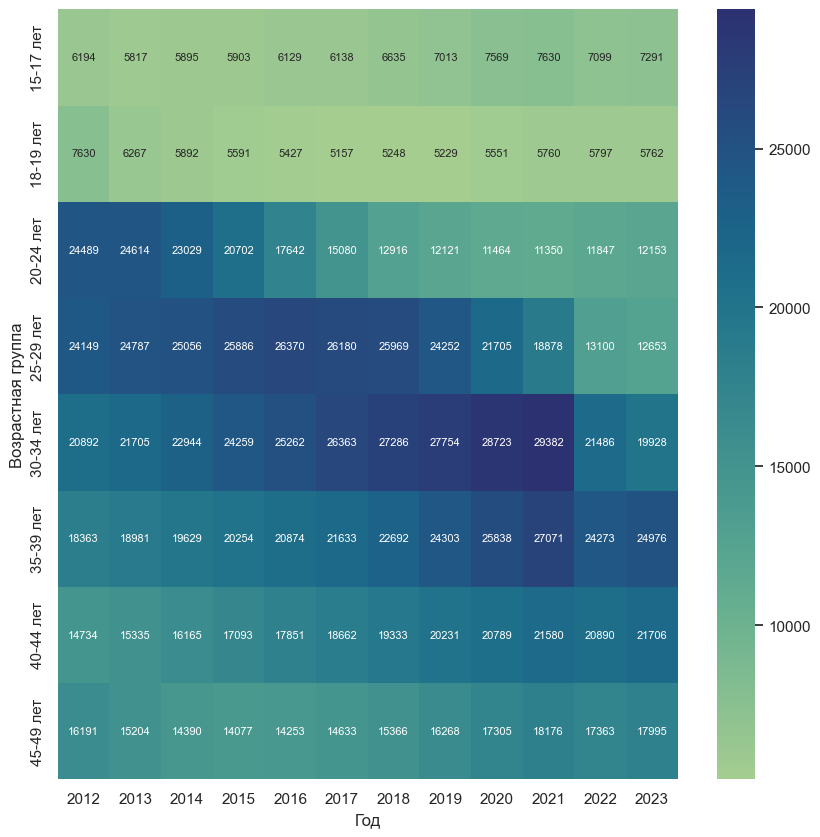

In [285]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(females_pt,annot=True, fmt=".0f", annot_kws={"size":8}, cmap="crest")

Saving figure Число женщин в возрастных группах


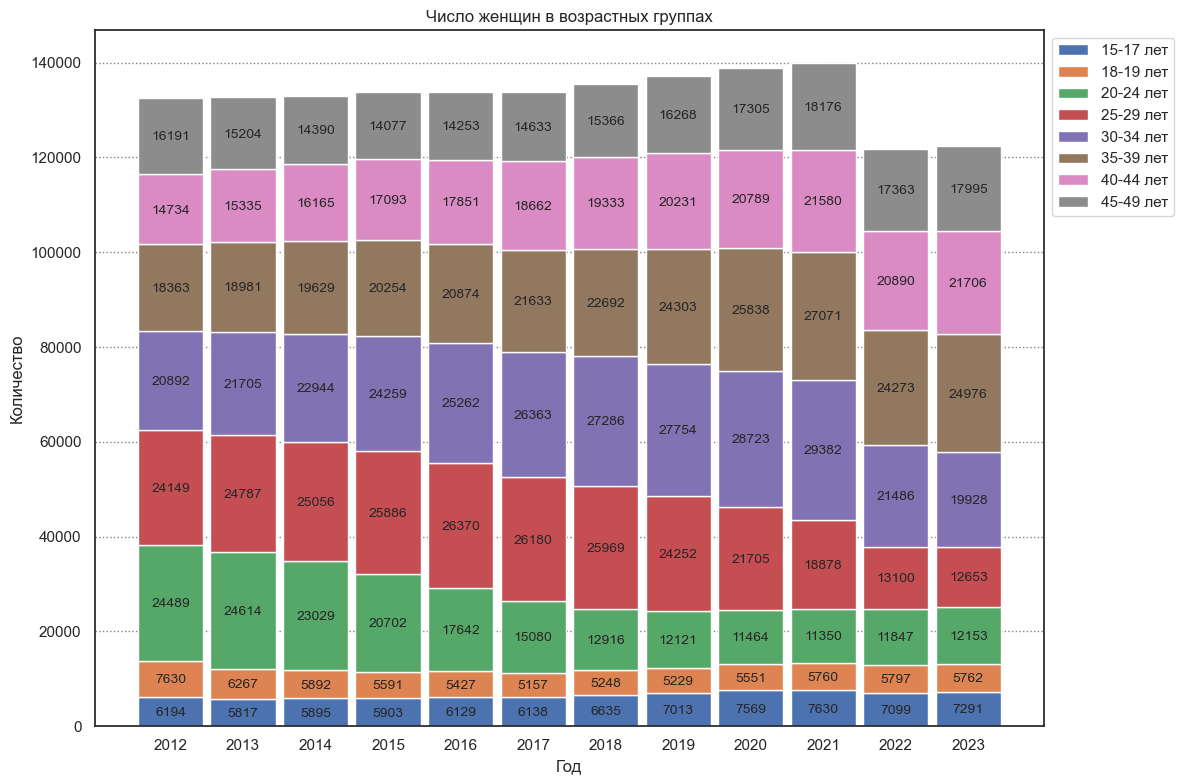

'.\\images\\Число женщин в возрастных группах.png'

In [286]:
plot_bar(females_pt.T, title='Число женщин в возрастных группах')

Saving figure Число женщин в возрастных группах


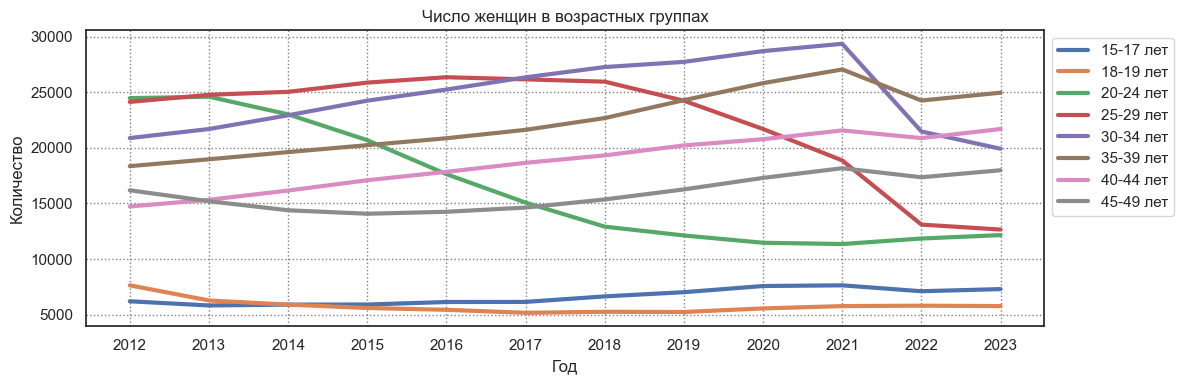

'.\\images\\Число женщин в возрастных группах.png'

In [287]:
plot_timeseries(females_pt.T,title='Число женщин в возрастных группах')

In [288]:
children_pt = pd.pivot_table(df_children_age, values=years, index=['Возрастная группа'], aggfunc="sum")
children_pt

Год,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Возрастная группа,,,,,,,,,,,,
0-1 год,11033,11524,12056,12466,13329,13949,12976,11683,10841,9796,9319.0,9085.0
2-3 года,10714,11184,11289,11757,12360,12710,13643,14445,13426,12128,10765.0,9655.0
4-6 лет,13707,14688,15808,16800,17283,17968,18612,19531,20608,21638,20782.0,19378.0
7-10 лет,16819,17525,17959,18910,19893,21265,22781,23878,25042,25935,23306.0,25586.0
11-14 лет,13962,14497,15307,16238,17190,17996,18538,19573,20636,22140,19617.0,20684.0
15-17 лет,12675,11775,11724,11803,12277,12488,13474,14361,15498,15627,14453.0,14989.0
18-19 лет,13901,12029,11296,10509,10174,9875,10103,10150,10944,11510,10873.0,10966.0


Saving figure Число детей в возрастных группах


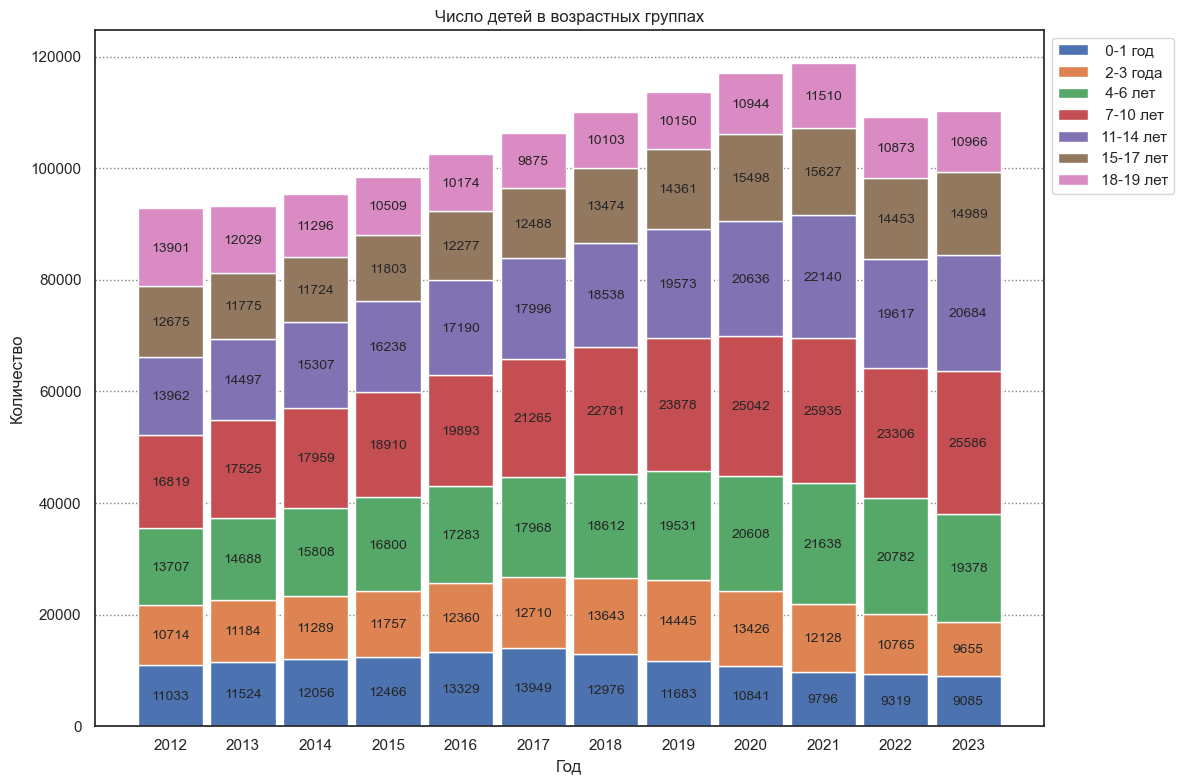

'.\\images\\Число детей в возрастных группах.png'

In [289]:
plot_bar(children_pt.T, title='Число детей в возрастных группах')

Saving figure Число детей в возрастных группах


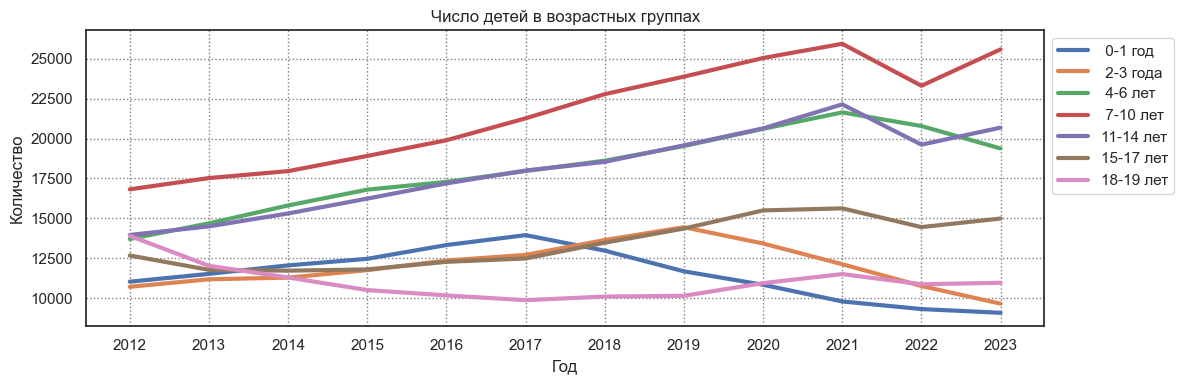

'.\\images\\Число детей в возрастных группах.png'

In [290]:
plot_timeseries(children_pt.T,title='Число детей в возрастных группах')

Text(0.5, 1.0, 'Количество детей в возрастных группах по годам')

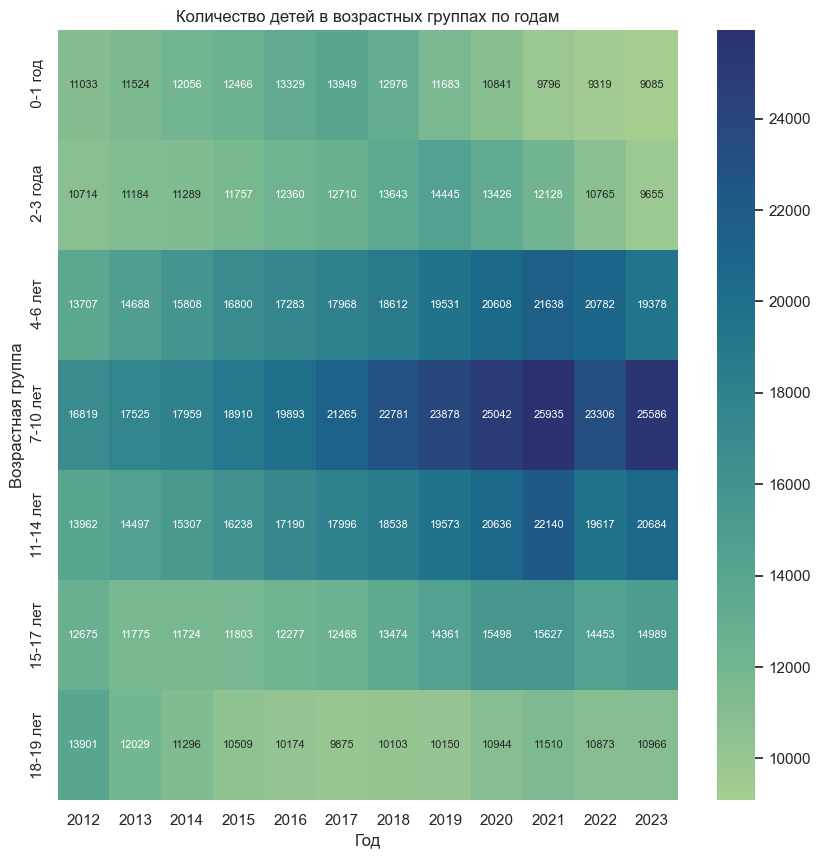

In [291]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(children_pt,annot=True, fmt=".0f", annot_kws={"size":8}, cmap="crest")
ax.set_title("Количество детей в возрастных группах по годам")

Saving figure Корреляция количества женщин детородного возраста и детей до 19 лет


'.\\images\\Корреляция количества женщин детородного возраста и детей до 19 лет.png'

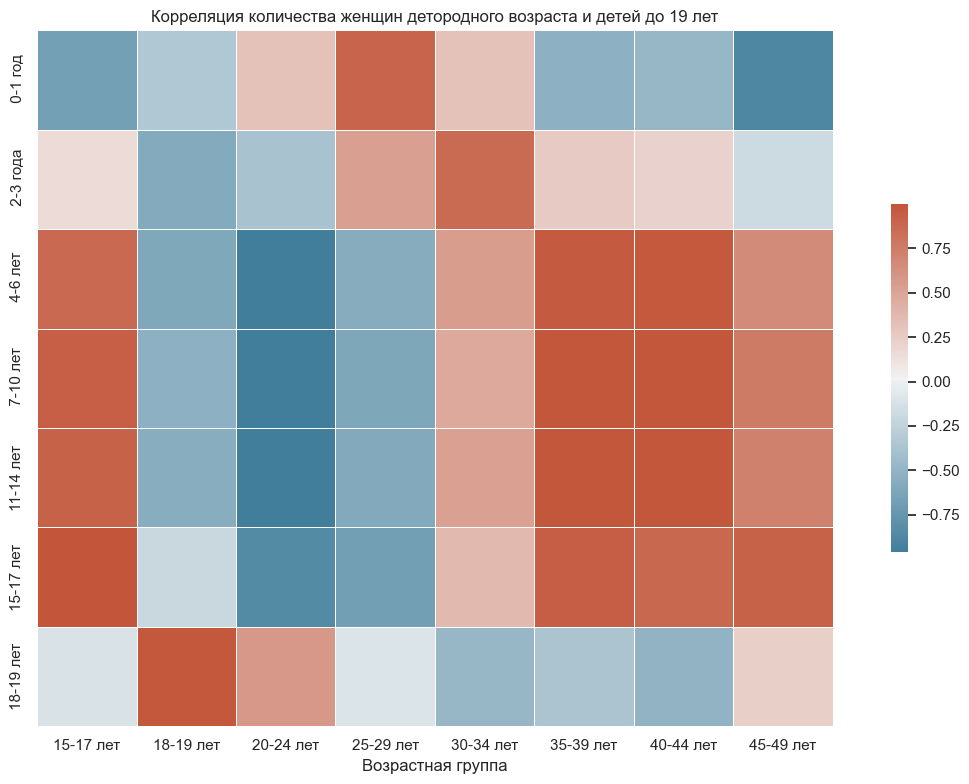

In [292]:
pt_corr = get_corr(females_pt.T, children_pt.T)
show_heatmap(pt_corr.T, square=True, title="Корреляция количества женщин детородного возраста и детей до 19 лет")

In [293]:
dou_df=pd.read_csv(dou_csv, sep=';', index_col=[0], encoding='cp1251', header = [1])
dou_df.dropna(axis=1, how='all', inplace=True)

In [294]:
dou_place_number_df=pd.read_csv(dou_place_number_csv, sep=';', index_col=[0], encoding='cp1251', header = [1])
dou_place_number_df.dropna(axis=1, how='all', inplace=True)

In [295]:
dou_students_number_df=pd.read_csv(dou_students_number_csv, sep=';', index_col=[0], encoding='cp1251', header = [1])
dou_students_number_df.dropna(axis=1, how='all', inplace=True)
dou_students_all_df = dou_students_number_df.loc[['Всего']].copy()

Saving figure Количество ДОУ (данные до 2019г)


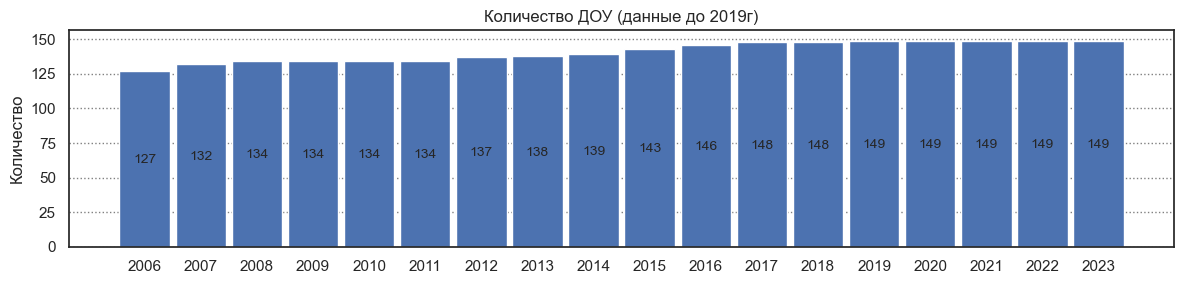

Saving figure Число мест в ДОУ


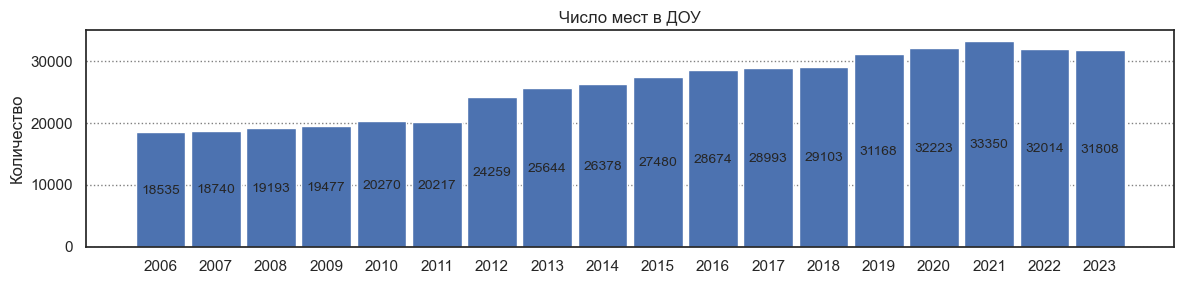

Saving figure Численность воспитанников ДОУ


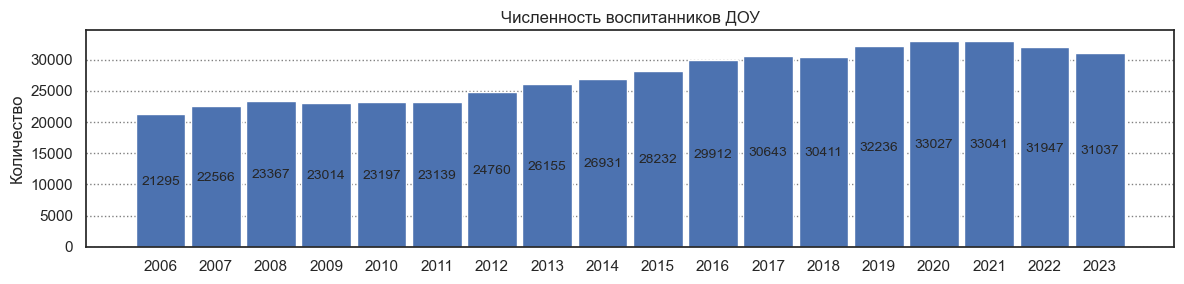

In [296]:
img_paths = [None,None,None]
img_paths[0] = plot_bar(dou_df.T, title='Количество ДОУ (данные до 2019г)', figsize=(12, 3))
img_paths[1] = plot_bar(dou_place_number_df.T, title='Число мест в ДОУ', figsize=(12, 3))
img_paths[2] = plot_bar(dou_students_all_df.T, title='Численность воспитанников ДОУ', figsize=(12, 3))
page_title="Дошкольные образовательные учреждения в период с 2006г по 2023г"
description = '''На графиках показаны количество ДОУ, общее число мест и воспитанников  вних. Как видно из графиков число ДОУ и количество в них мест увеличивается.'''
pdf_add_page(page_title, img_paths, description)

In [297]:
dou_students_ages_df = dou_students_number_df.iloc[1:].copy()
dou_students_ages_df.dropna(axis=1, how='all', inplace=True)
dou_students_ages_df.fillna(0, inplace=True)
students_columns = dou_students_ages_df.columns

Saving figure Количество воспитанников ДОУ до 3 лет_Количество воспитанников ДОУ старше 3 лет


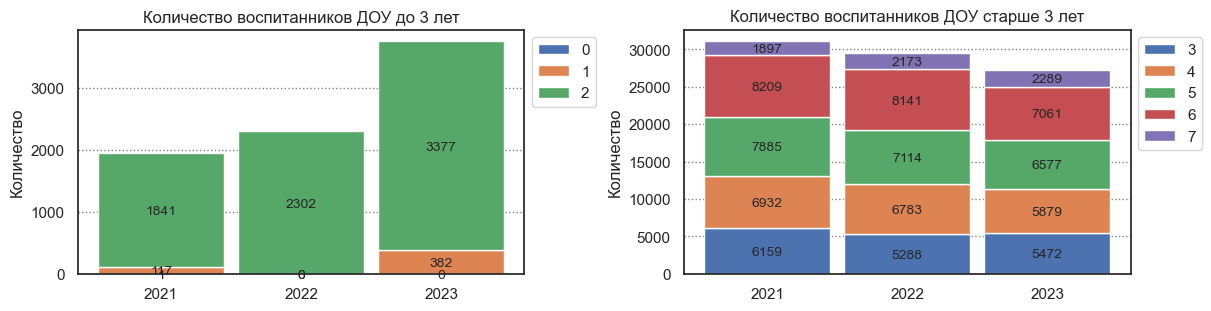

Saving figure Количество воспитанников ДОУ до 3 лет_Общее число детей в возрасте от 1 года до 3 лет


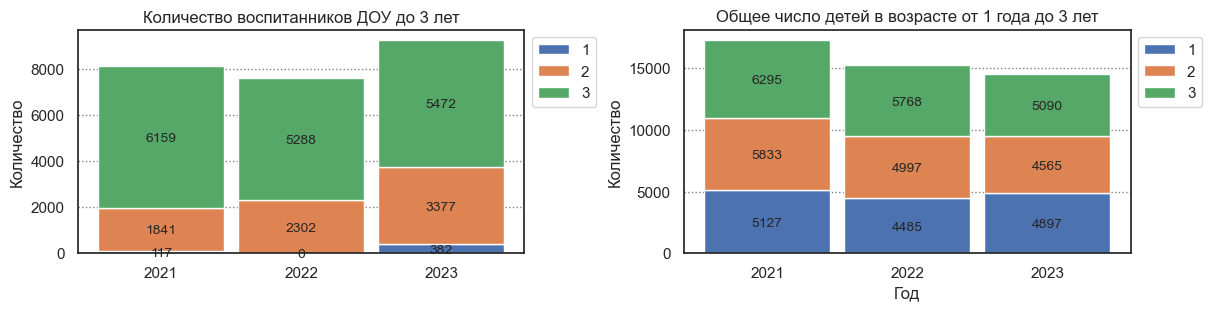

Saving figure Количество мест в ДОУ_Общее число детей в возрасте от 1 года до 6 лет


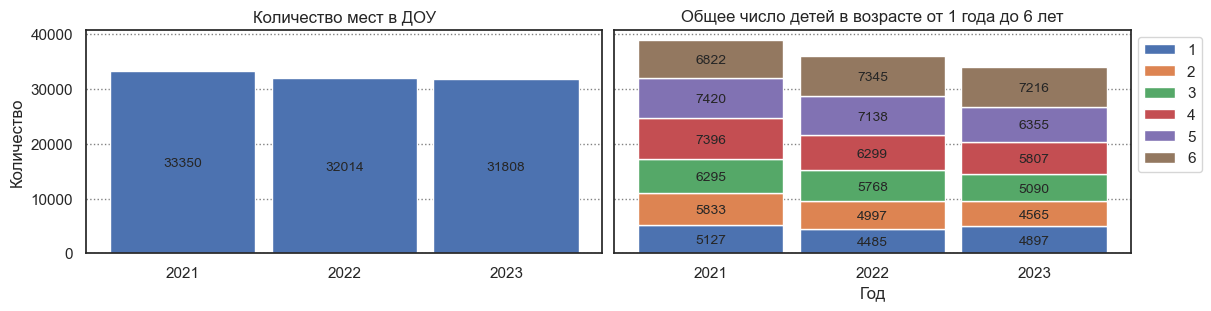

In [298]:
img_paths = [None,None,None]
img_paths[0] = subplot_bar(dou_students_ages_df.iloc[:3].T,dou_students_ages_df.iloc[3:].T, 
            title=['Количество воспитанников ДОУ до 3 лет',  'Количество воспитанников ДОУ старше 3 лет'], figsize = (12,3))
img_paths[1] = subplot_bar(dou_students_ages_df.iloc[1:4].T,df_children[students_columns].iloc[1:4].T, 
            title=['Количество воспитанников ДОУ до 3 лет', 'Общее число детей в возрасте от 1 года до 3 лет'], figsize = (12,3))
img_paths[2] = subplot_bar(dou_place_number_df[students_columns].T,df_children[students_columns].iloc[1:7].T, 
            title=['Количество мест в ДОУ', 'Общее число детей в возрасте от 1 года до 6 лет'], figsize = (12,3), sharey=True)
page_title="Дошкольные образовательные учреждения в период с 2021г по 2023г. Деталировка."
description = '''На графиках показаны количество ДОУ, общее число мест и воспитанников  вних в возрастных группах до 7 лет.
Как видно из графиков количество мест для детей до 3 лет увеличивается. Увеличение числа воспинанников в возрасте до 3 лет определяется и увеличением количества мест в  ДОУ, и снижением количества воспитанников в возрасте 4-7 лет.'''
pdf_add_page(page_title, img_paths, description)

In [299]:
def trend_forcast(y, fh=[1, 2, 3]):
    y.index = y.index.astype('int64')
    # step 2: specifying forecasting horizon
    fh = [1,2,3,4,5]
    forecaster = TrendForecaster()
    forecaster.fit(y)
    y_pred = forecaster.predict(fh=fh)
    fig, ax = plotting.plot_series(
        y, y_pred, labels=[y.name, y.name+" прогноз"])
    ax.legend()   
    return y_pred

2024    4646.848485
2025    4488.761072
2026    4330.673660
2027    4172.586247
2028    4014.498834
Name: 0, dtype: float64

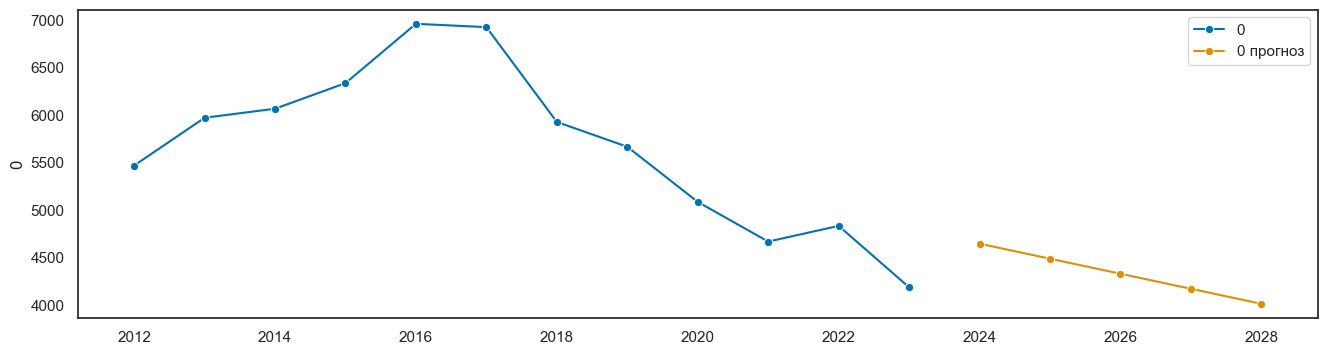

In [300]:
trend_forcast(df_children.T['0'],fh = [1,2,3,4,5])

In [301]:
def theta_forecaster(y, fh=[1, 2, 3], sp=4, coverage = 0.9):
#    y = df_children.T['0']
    y.index = y.index.astype('int64')
    forecaster = ThetaForecaster(sp=sp)
    forecaster.fit(y, fh=fh)
#    coverage = 0.9
    y_pred_ints = forecaster.predict_interval(coverage=coverage)
    y_pred = forecaster.predict()

    fig, ax = plotting.plot_series(
        y, y_pred, labels=[y.name, y.name+" прогноз"], pred_interval=y_pred_ints
    )
    ax.legend()
    return y_pred, y_pred_ints


(2024    4137.603982
 2025    4040.623337
 2026    3813.337991
 2027    3810.544927
 2028    3828.116205
 Name: 0, dtype: float64,
                 0             
              0.95             
             lower        upper
 2024  2776.872427  5498.335538
 2025  2374.074348  5707.172326
 2026  1888.972978  5737.703004
 2027  1659.039438  5962.050417
 2028  1471.260028  6184.972382)

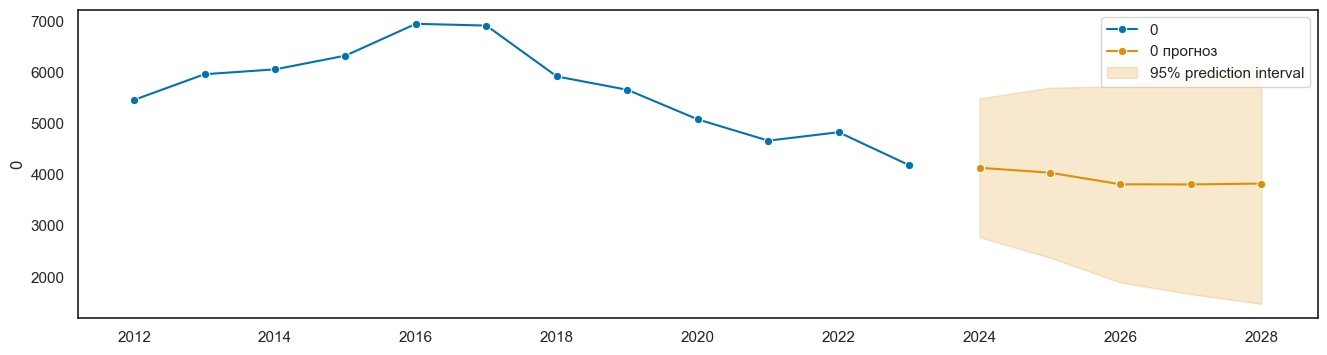

In [302]:
theta_forecaster(df_children.T['0'], fh = [1,2,3,4,5], sp=4, coverage = 0.95)

In [303]:
children_pt

Год,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Возрастная группа,,,,,,,,,,,,
0-1 год,11033,11524,12056,12466,13329,13949,12976,11683,10841,9796,9319.0,9085.0
2-3 года,10714,11184,11289,11757,12360,12710,13643,14445,13426,12128,10765.0,9655.0
4-6 лет,13707,14688,15808,16800,17283,17968,18612,19531,20608,21638,20782.0,19378.0
7-10 лет,16819,17525,17959,18910,19893,21265,22781,23878,25042,25935,23306.0,25586.0
11-14 лет,13962,14497,15307,16238,17190,17996,18538,19573,20636,22140,19617.0,20684.0
15-17 лет,12675,11775,11724,11803,12277,12488,13474,14361,15498,15627,14453.0,14989.0
18-19 лет,13901,12029,11296,10509,10174,9875,10103,10150,10944,11510,10873.0,10966.0


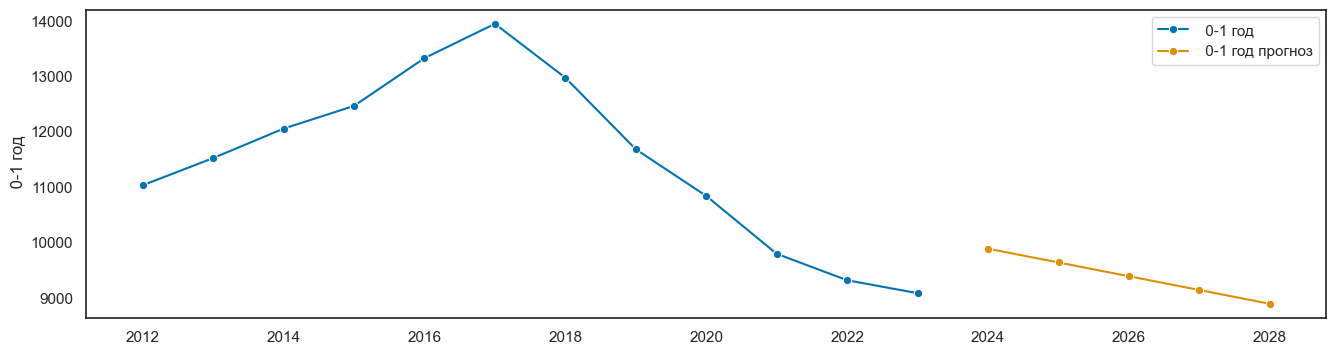

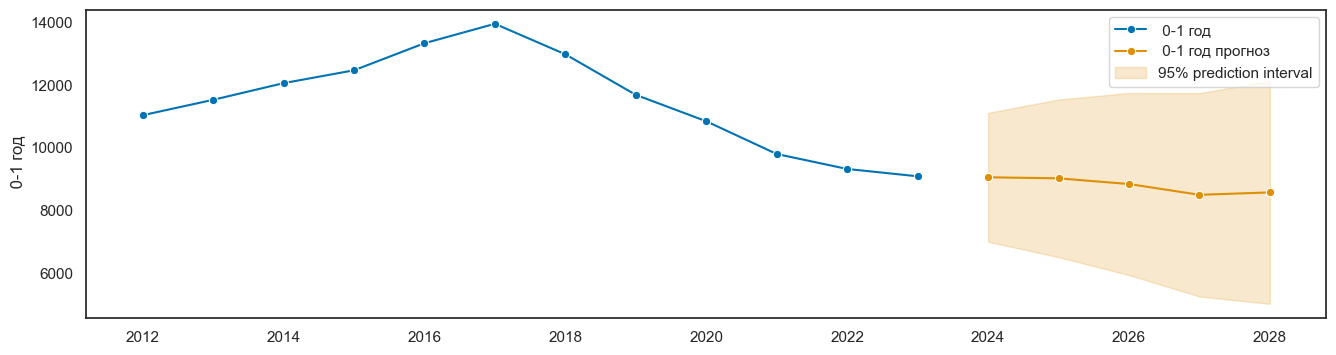

In [304]:
tr_f = trend_forcast(children_pt.T[' 0-1 год'],fh = [1,2,3,4,5])
th_f = theta_forecaster(children_pt.T[' 0-1 год'], fh = [1,2,3,4,5], sp=4, coverage = 0.95)

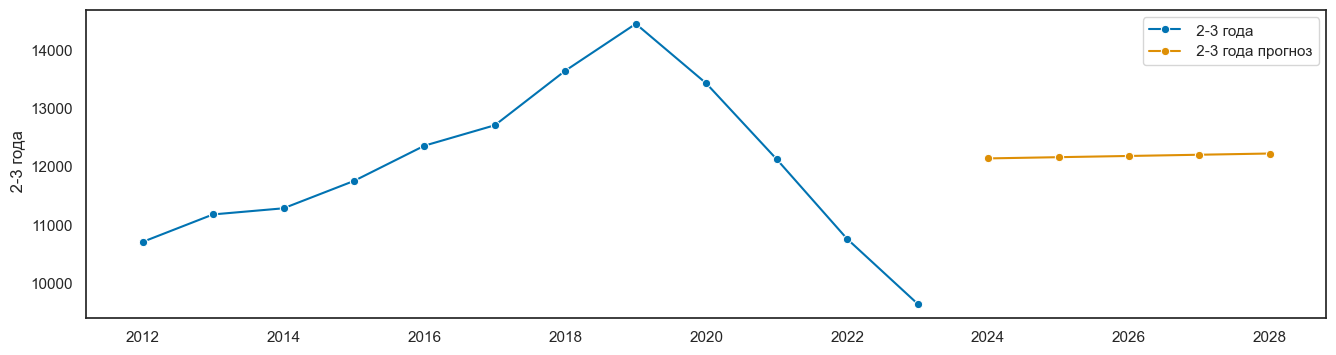

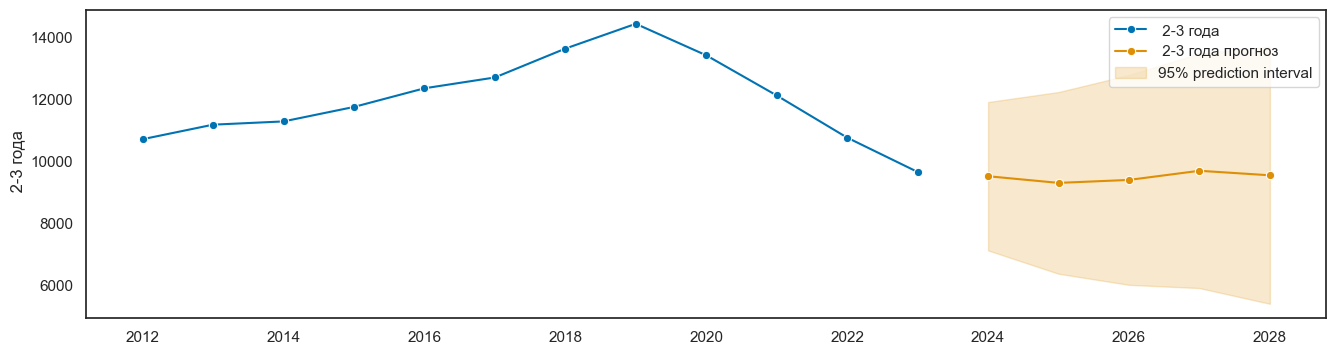

In [305]:
tr_f = trend_forcast(children_pt.T[' 2-3 года'],fh = [1,2,3,4,5])
th_f = theta_forecaster(children_pt.T[' 2-3 года'], fh = [1,2,3,4,5], sp=4, coverage = 0.95)

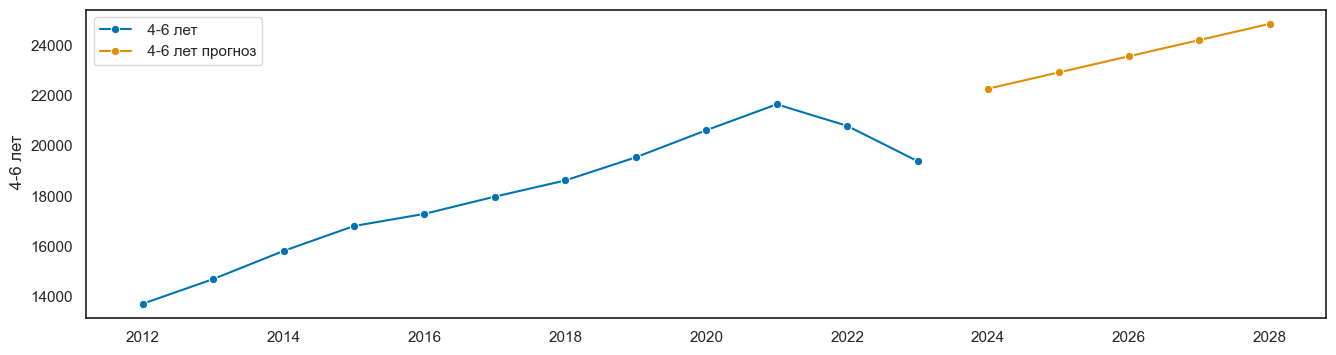

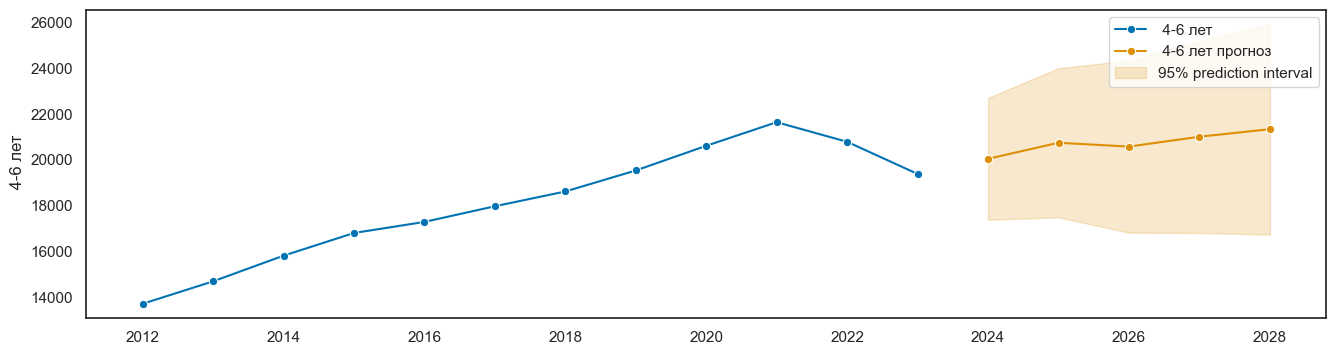

In [306]:
tr_f = trend_forcast(children_pt.T[' 4-6 лет'],fh = [1,2,3,4,5])
th_f = theta_forecaster(children_pt.T[' 4-6 лет'], fh = [1,2,3,4,5], sp=4, coverage = 0.95)

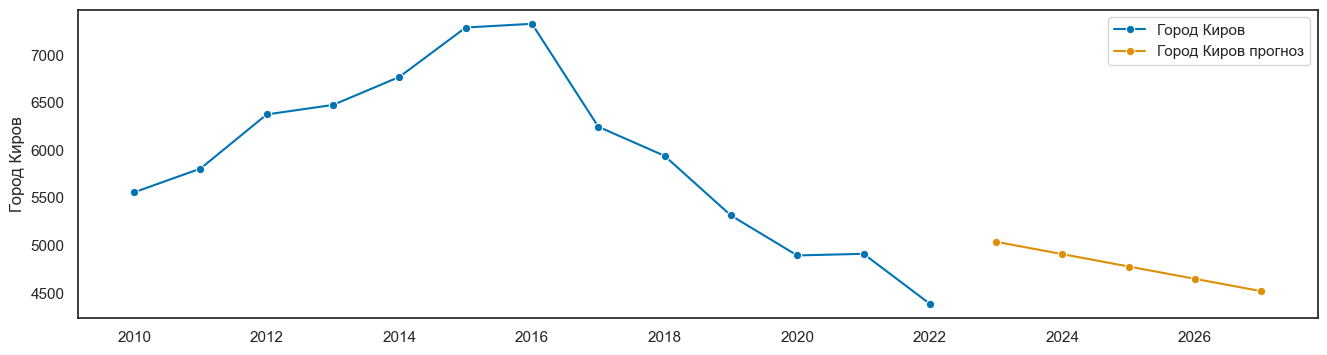

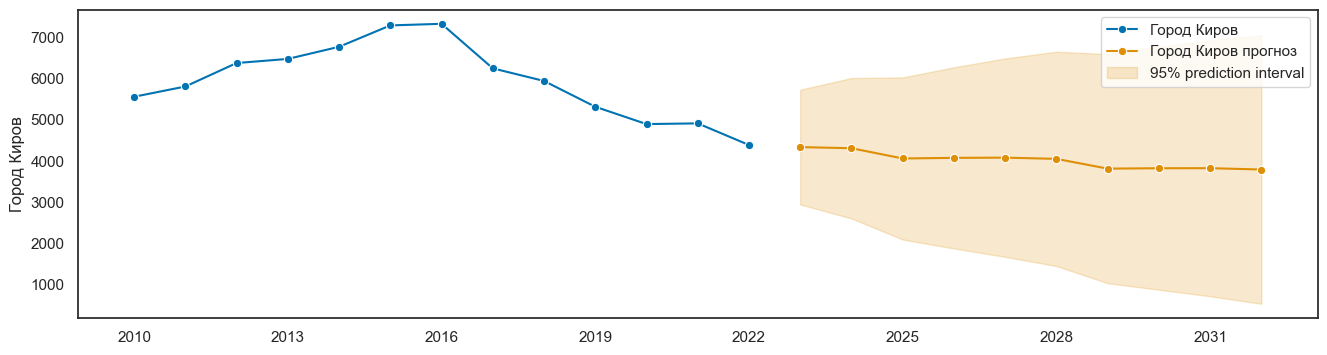

In [307]:
#births_number_df
tr_f = trend_forcast(births_number_df.iloc[0],fh = [1,2,3,4,5,6,7,8,9,10])
th_f = theta_forecaster(births_number_df.iloc[0], fh = [1,2,3,4,5,6,7,8,9,10], sp=4, coverage = 0.95)

In [308]:
dft = population_df['Всего'].iloc[0:70].T
dft.index = dft.index.astype('int64')
dft

Возраст,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
Год,,,,,,,,,,,,,,,,,,,,,
2012,5468.0,5565.0,5502.0,5212.0,4882.0,4483.0,4342.0,4502.0,4239.0,4272.0,...,6704.0,6489.0,6603.0,5177.0,5447.0,4494.0,2292.0,1511.0,1123.0,2077.0
2013,5971.0,5553.0,5652.0,5532.0,5249.0,4902.0,4537.0,4411.0,4535.0,4271.0,...,6751.0,6578.0,6372.0,6445.0,5064.0,5323.0,4390.0,2226.0,1461.0,1094.0
2014,6066.0,5990.0,5591.0,5698.0,5548.0,5297.0,4963.0,4653.0,4454.0,4558.0,...,6555.0,6662.0,6423.0,6220.0,6309.0,4955.0,5203.0,4301.0,2156.0,1421.0
2015,6335.0,6131.0,6079.0,5678.0,5783.0,5628.0,5389.0,5115.0,4688.0,4499.0,...,7095.0,6458.0,6555.0,6358.0,6102.0,6216.0,4863.0,5129.0,4216.0,2104.0
2016,6959.0,6370.0,6200.0,6160.0,5742.0,5847.0,5694.0,5539.0,5124.0,4721.0,...,7101.0,6993.0,6350.0,6465.0,6234.0,5986.0,6083.0,4739.0,5000.0,4089.0
2017,6924.0,7025.0,6436.0,6274.0,6228.0,5790.0,5950.0,5810.0,5545.0,5172.0,...,6596.0,6991.0,6883.0,6279.0,6359.0,6139.0,5888.0,5947.0,4649.0,4873.0
2018,5927.0,7049.0,7134.0,6509.0,6328.0,6353.0,5931.0,6095.0,5883.0,5587.0,...,7130.0,6514.0,6919.0,6798.0,6175.0,6220.0,6051.0,5810.0,5824.0,4553.0
2019,5666.0,6017.0,7206.0,7239.0,6596.0,6430.0,6505.0,6110.0,6165.0,5952.0,...,7023.0,7042.0,6424.0,6843.0,6723.0,6084.0,6116.0,5925.0,5693.0,5694.0
2020,5086.0,5755.0,6142.0,7284.0,7321.0,6693.0,6594.0,6657.0,6177.0,6220.0,...,7124.0,6958.0,6957.0,6341.0,6740.0,6647.0,5988.0,5993.0,5800.0,5577.0


In [309]:
x_col = dft.columns[1:]
X = np.array(dft[x_col]).tolist()
y_col = dft.columns[0]
y = np.array(dft[y_col]).tolist()
dft_index = dft.index

In [310]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [311]:
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)
gpr.score(X, y)

0.9999999999999951

In [312]:
y_pred = gpr.predict(X, return_std=True)
y_pred

(array([5468.00001803, 5970.99994841, 6066.00006421, 6335.0000459 ,
        6958.99993669, 6923.99987452, 5927.00006781, 5666.00005305,
        5085.99999898, 4669.00001072, 4833.99994779, 4188.0000291 ]),
 array([1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
        1.41421356, 1.41421373, 1.41421356, 1.41421356, 1.41421356,
        1.41421339, 1.41421356]))

Saving figure Прогноз числа детей


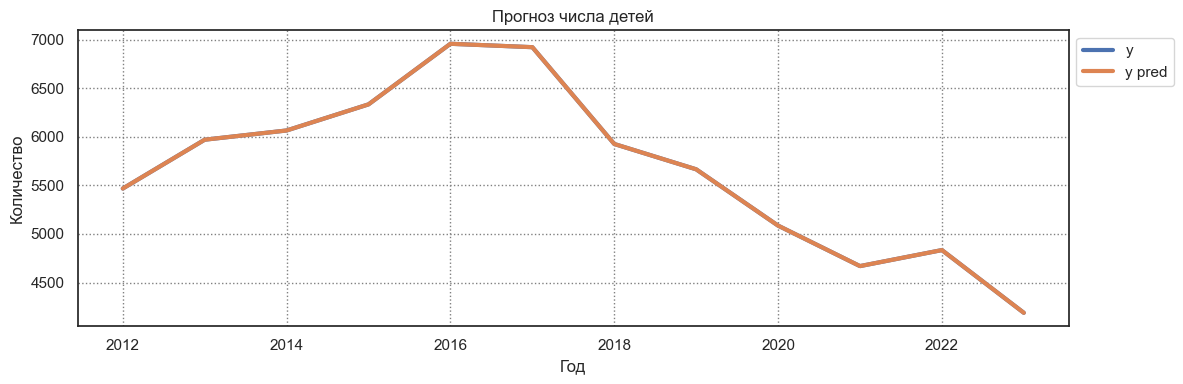

'.\\images\\Прогноз числа детей.png'

In [313]:
y_df = DataFrame(zip(y, y_pred[0].tolist()),columns=['y', 'y pred'], index = dft.index)
plot_timeseries(y_df,title='Прогноз числа детей')

Saving figure Прогноз рождаемости


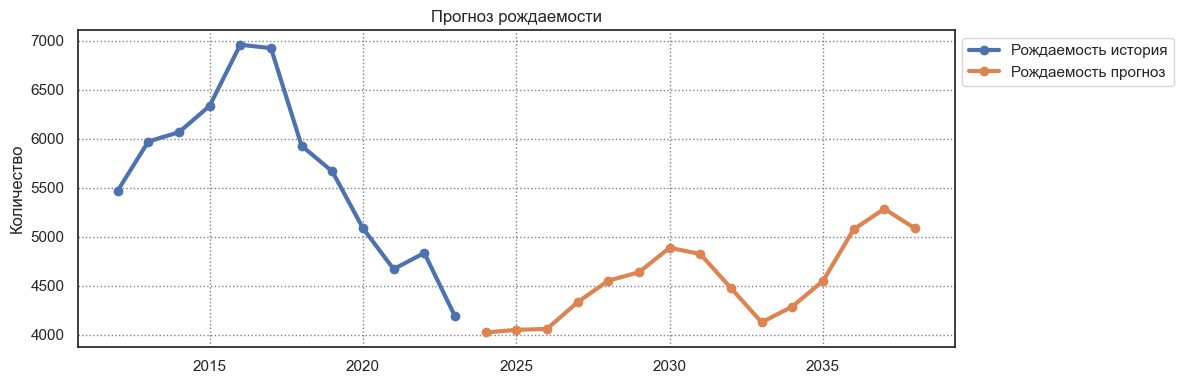

In [314]:
#Выбираем последнюю строку
x_col = dft.columns[:-1]
x_index = dft.index[-1]
# Датафрейм Y исходные для графика
y_index = dft.index
y_df = DataFrame(y,columns=['Рождаемость история'], index = y_index)
# Формируем датафрейм из последней строки
df_x = dft[x_col].loc[[x_index]]
#y_pred_df = DataFrame(y_df.loc[x_index].astype('int64').tolist(),columns=['y pred'], index = x_index)
y_pred_df = DataFrame()

for i in range(15):
    Xp = np.array(df_x).tolist()
    y_pred = gpr.predict(Xp, return_std=True)
    #Определили новый индекс
    x_index = df_x.index[-1]
    index_p = pd.Index([x_index + 1])
    #Датафрейм с предсказанием
    y_pred_new = DataFrame(y_pred[0].astype('int64').tolist(),columns=['Рождаемость прогноз'], index = index_p)
    y_pred_df = pd.concat([y_pred_df, y_pred_new])

    new_col = str(int(x_col[0]) - 1)
    x_col = x_col[:-1].insert(0, new_col)
    df_x[new_col] = y_pred[0].astype('int64').tolist()
    df_x = df_x.reindex(x_col, axis="columns")
    df_x.index = index_p
    df_x = df_x[x_col]

#Вывод графиков исторические данные и предсказание
y_comparation_df = pd.concat([y_df, y_pred_df])
img_path = plot_timeseries(y_comparation_df,title='Прогноз рождаемости', marker = 'o')

In [315]:
page_title="Прогноз рождаемости на период до 2038г"
description = '''На графике показана фактическая рожаемость в период 2012-2023гг и прогноз до 2038г. Прогноз сделан регрессионным методом.
Как видно на графике, в ближайшие несколько лет рожаемость несколько снизится, а потом вероятен рост рождаемости.
Учитывая увеличение мест в ДОУ и умеренный рост рождаемости можно предположить что муниципальные ДОУ полностью удовлетворят потребность для детей от года до 7 лет.'''
pdf_add_page(page_title, [img_path], description)

In [316]:
pdf.output(pdf_filename)

''